## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load

In [2]:
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

input_shape = X_train_val.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128)
Shape of y_train: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


# Inspect Images

Training set images: 2615


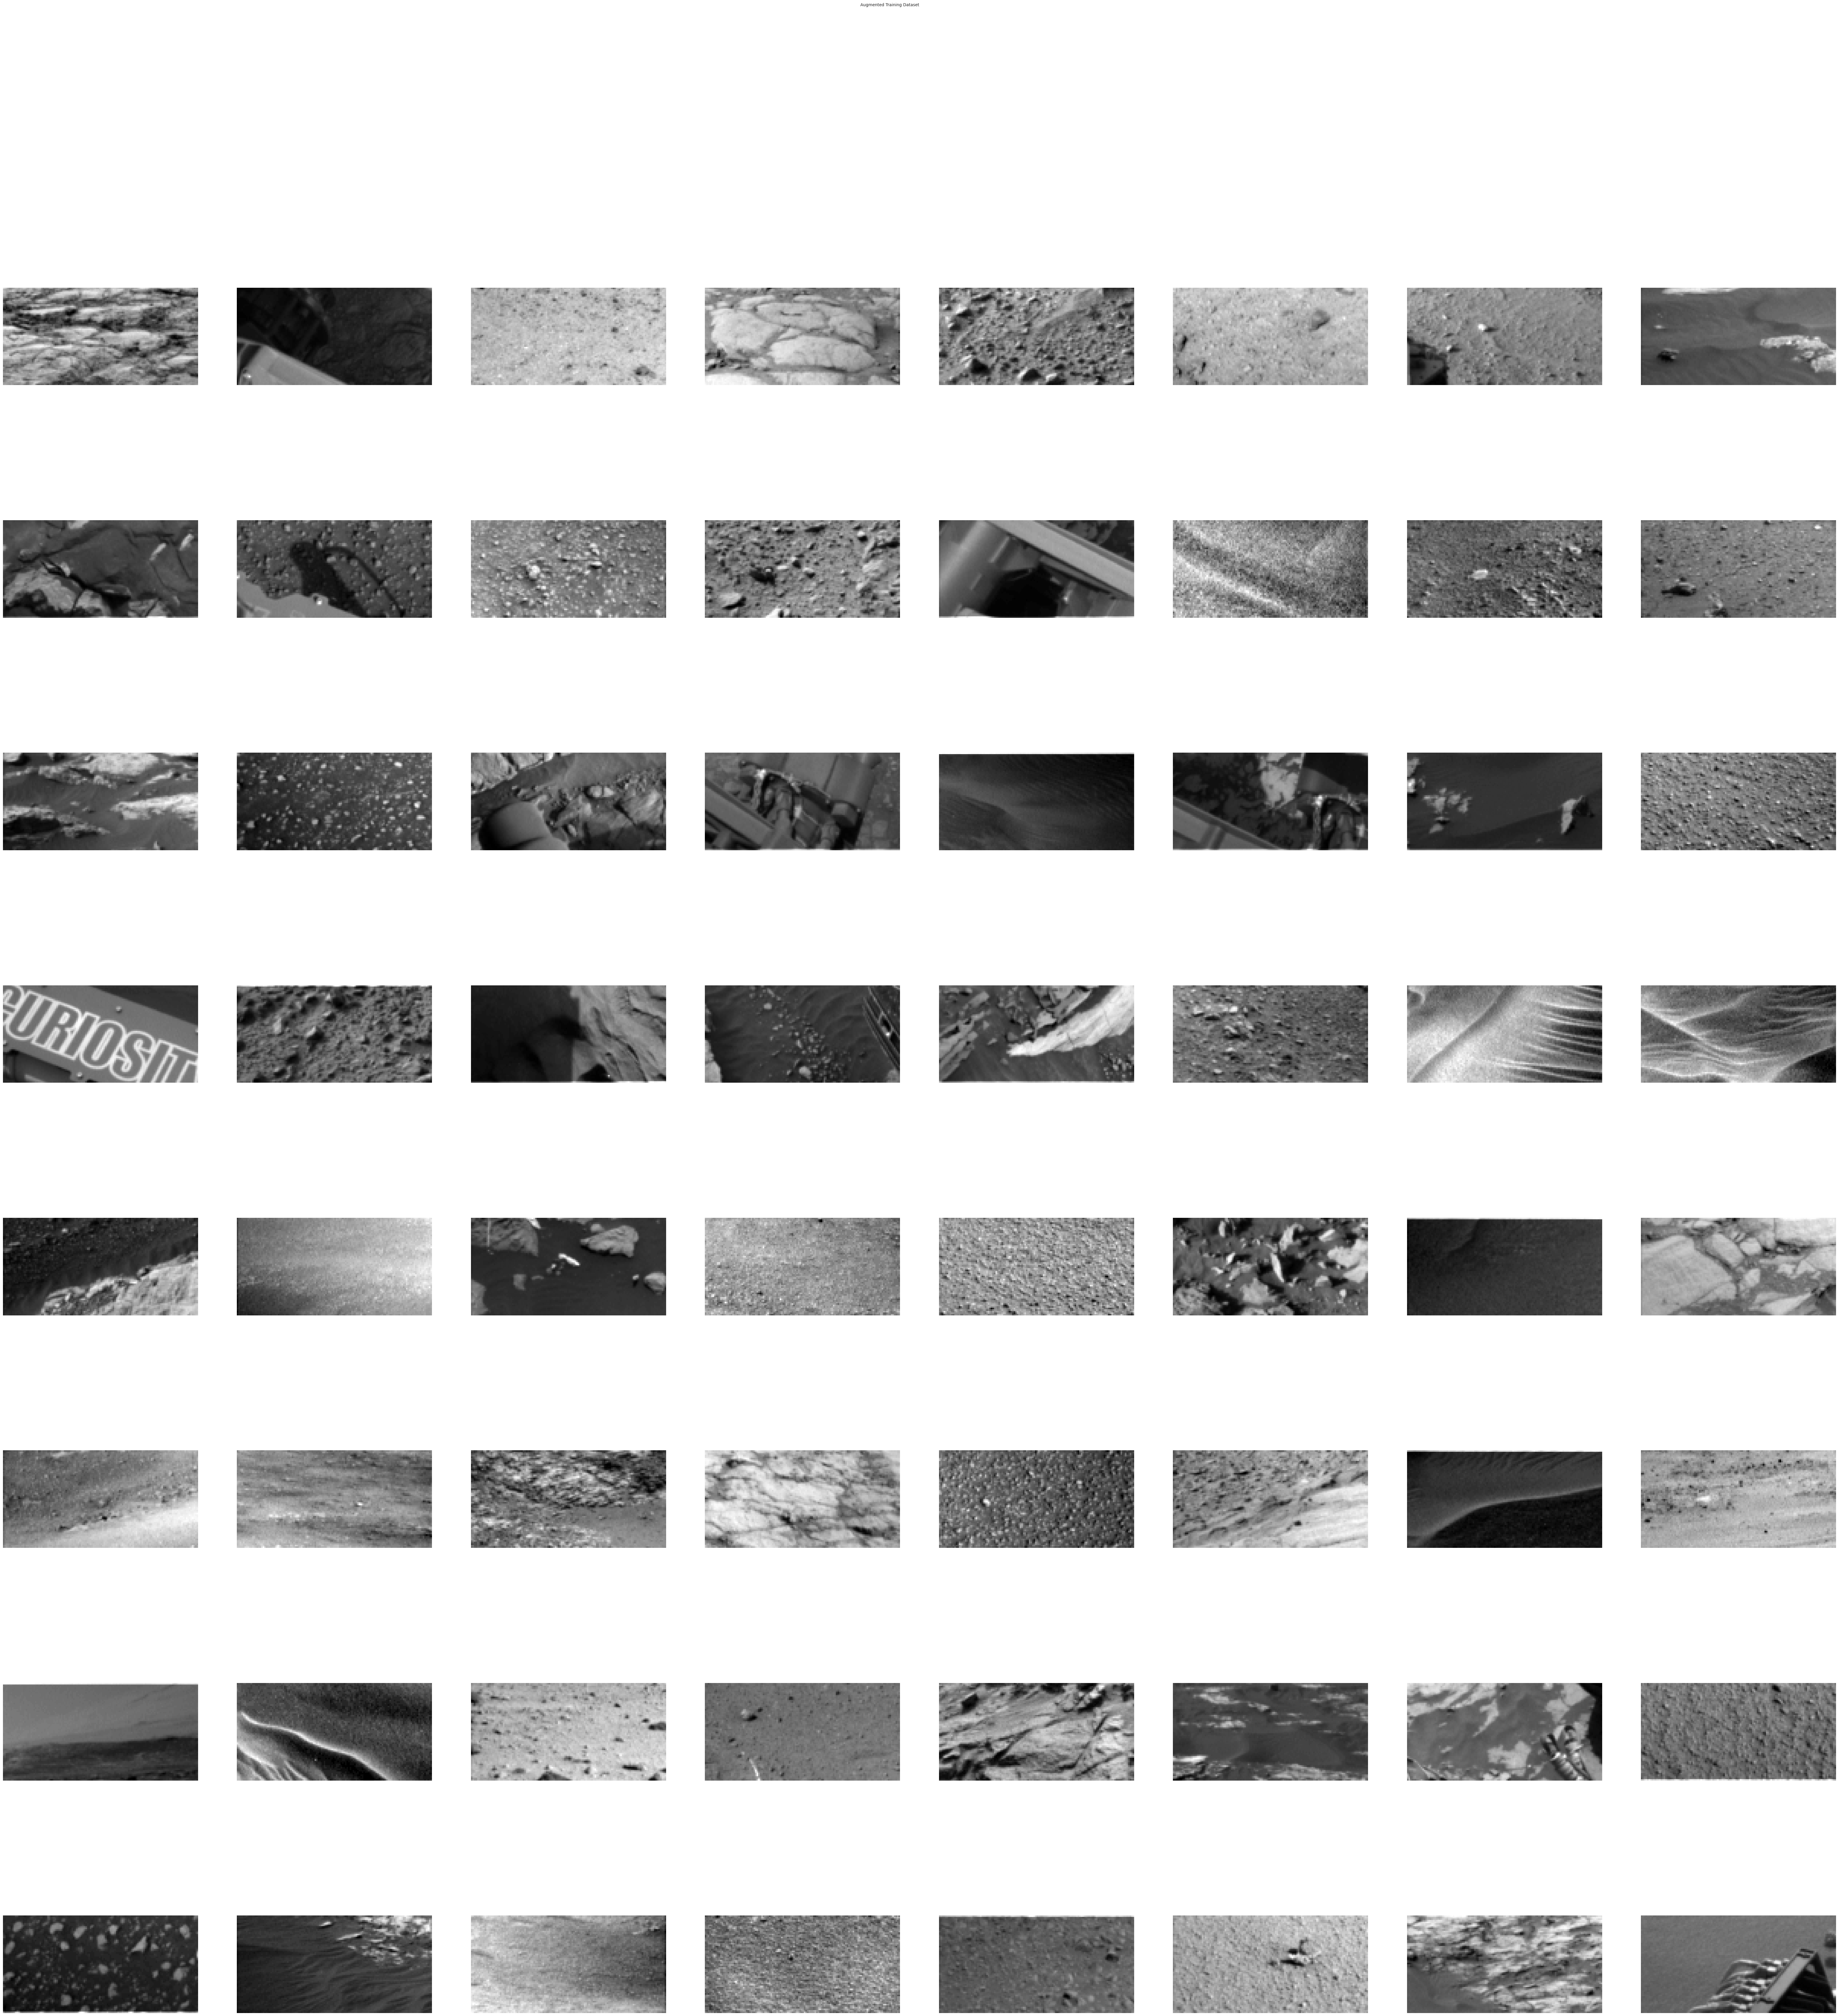

In [3]:
def visualize_dataset(dataset, title, image_size=(10, 10), grid_size=(8, 8)):
    print("Training set images:", len(dataset))

    num_images_to_plot = grid_size[0] * grid_size[1]
    random_indices = random.sample(range(len(dataset)), num_images_to_plot)
    sampled_images = [dataset[i] for i in random_indices]
    
    figsize = (grid_size[1] * image_size[0], grid_size[0] * image_size[1])
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=10)
    for i, image in enumerate(sampled_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image, cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.show()

visualize_dataset(X_train_val, "Augmented Training Dataset")

## 👽 Detect Outliers

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


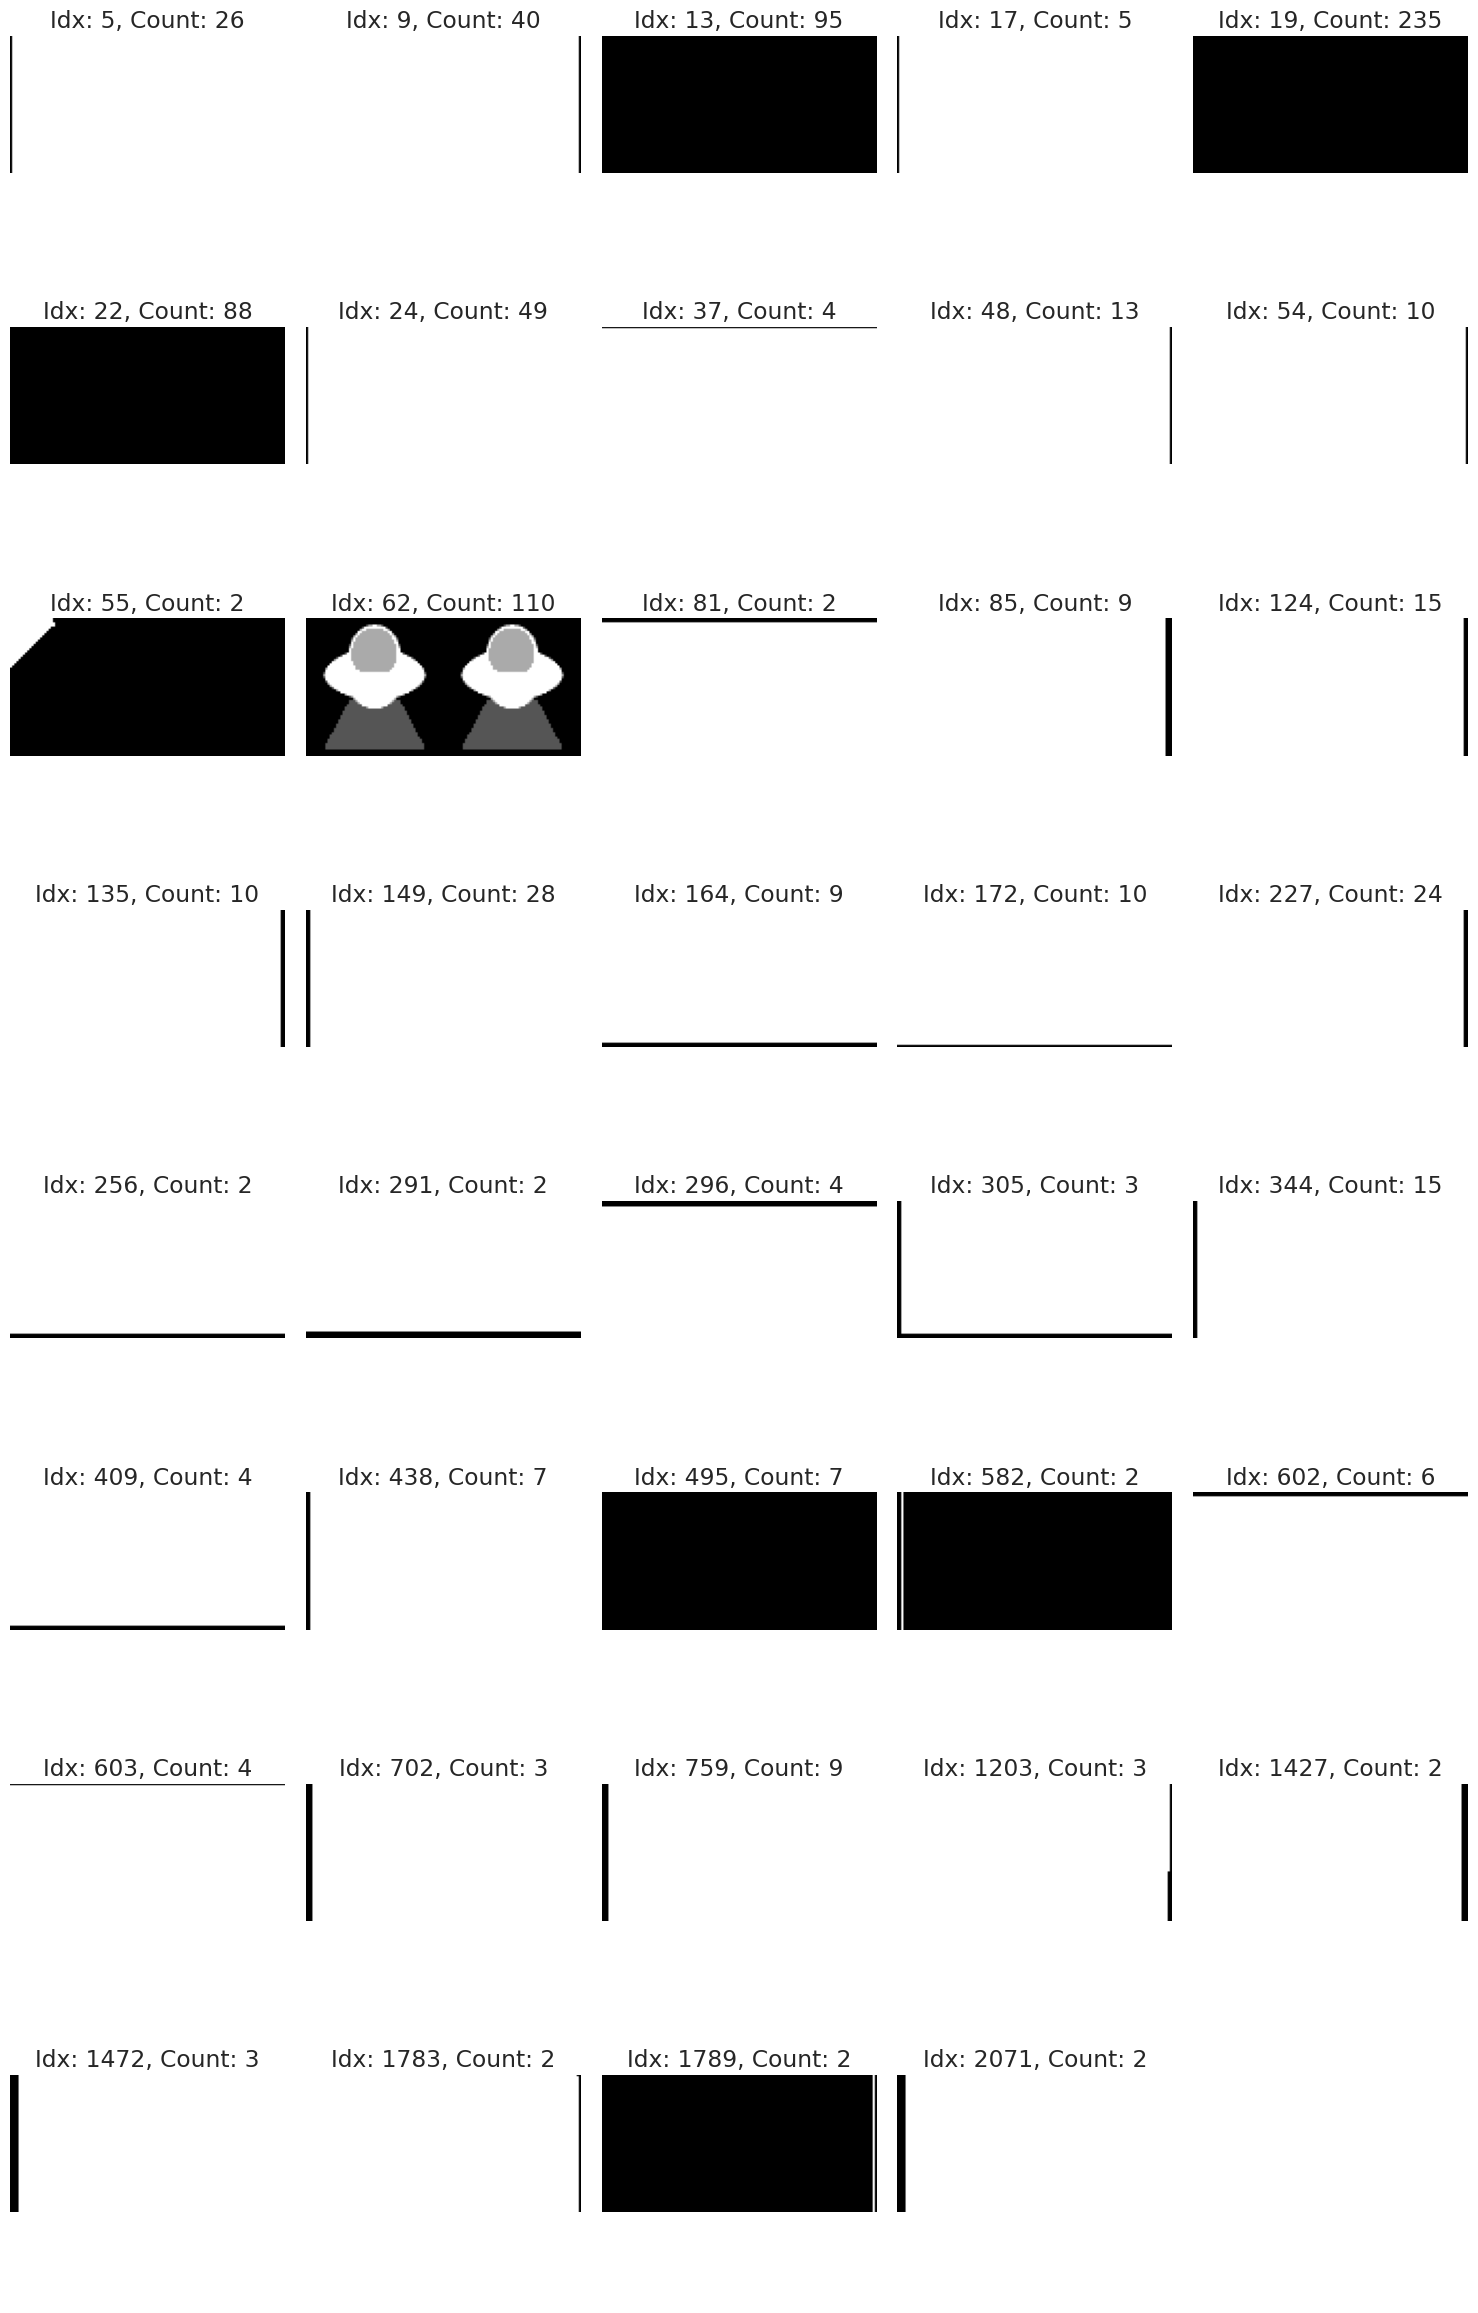

In [5]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        ax.imshow(y_train_val[representative_idx])
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [7]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


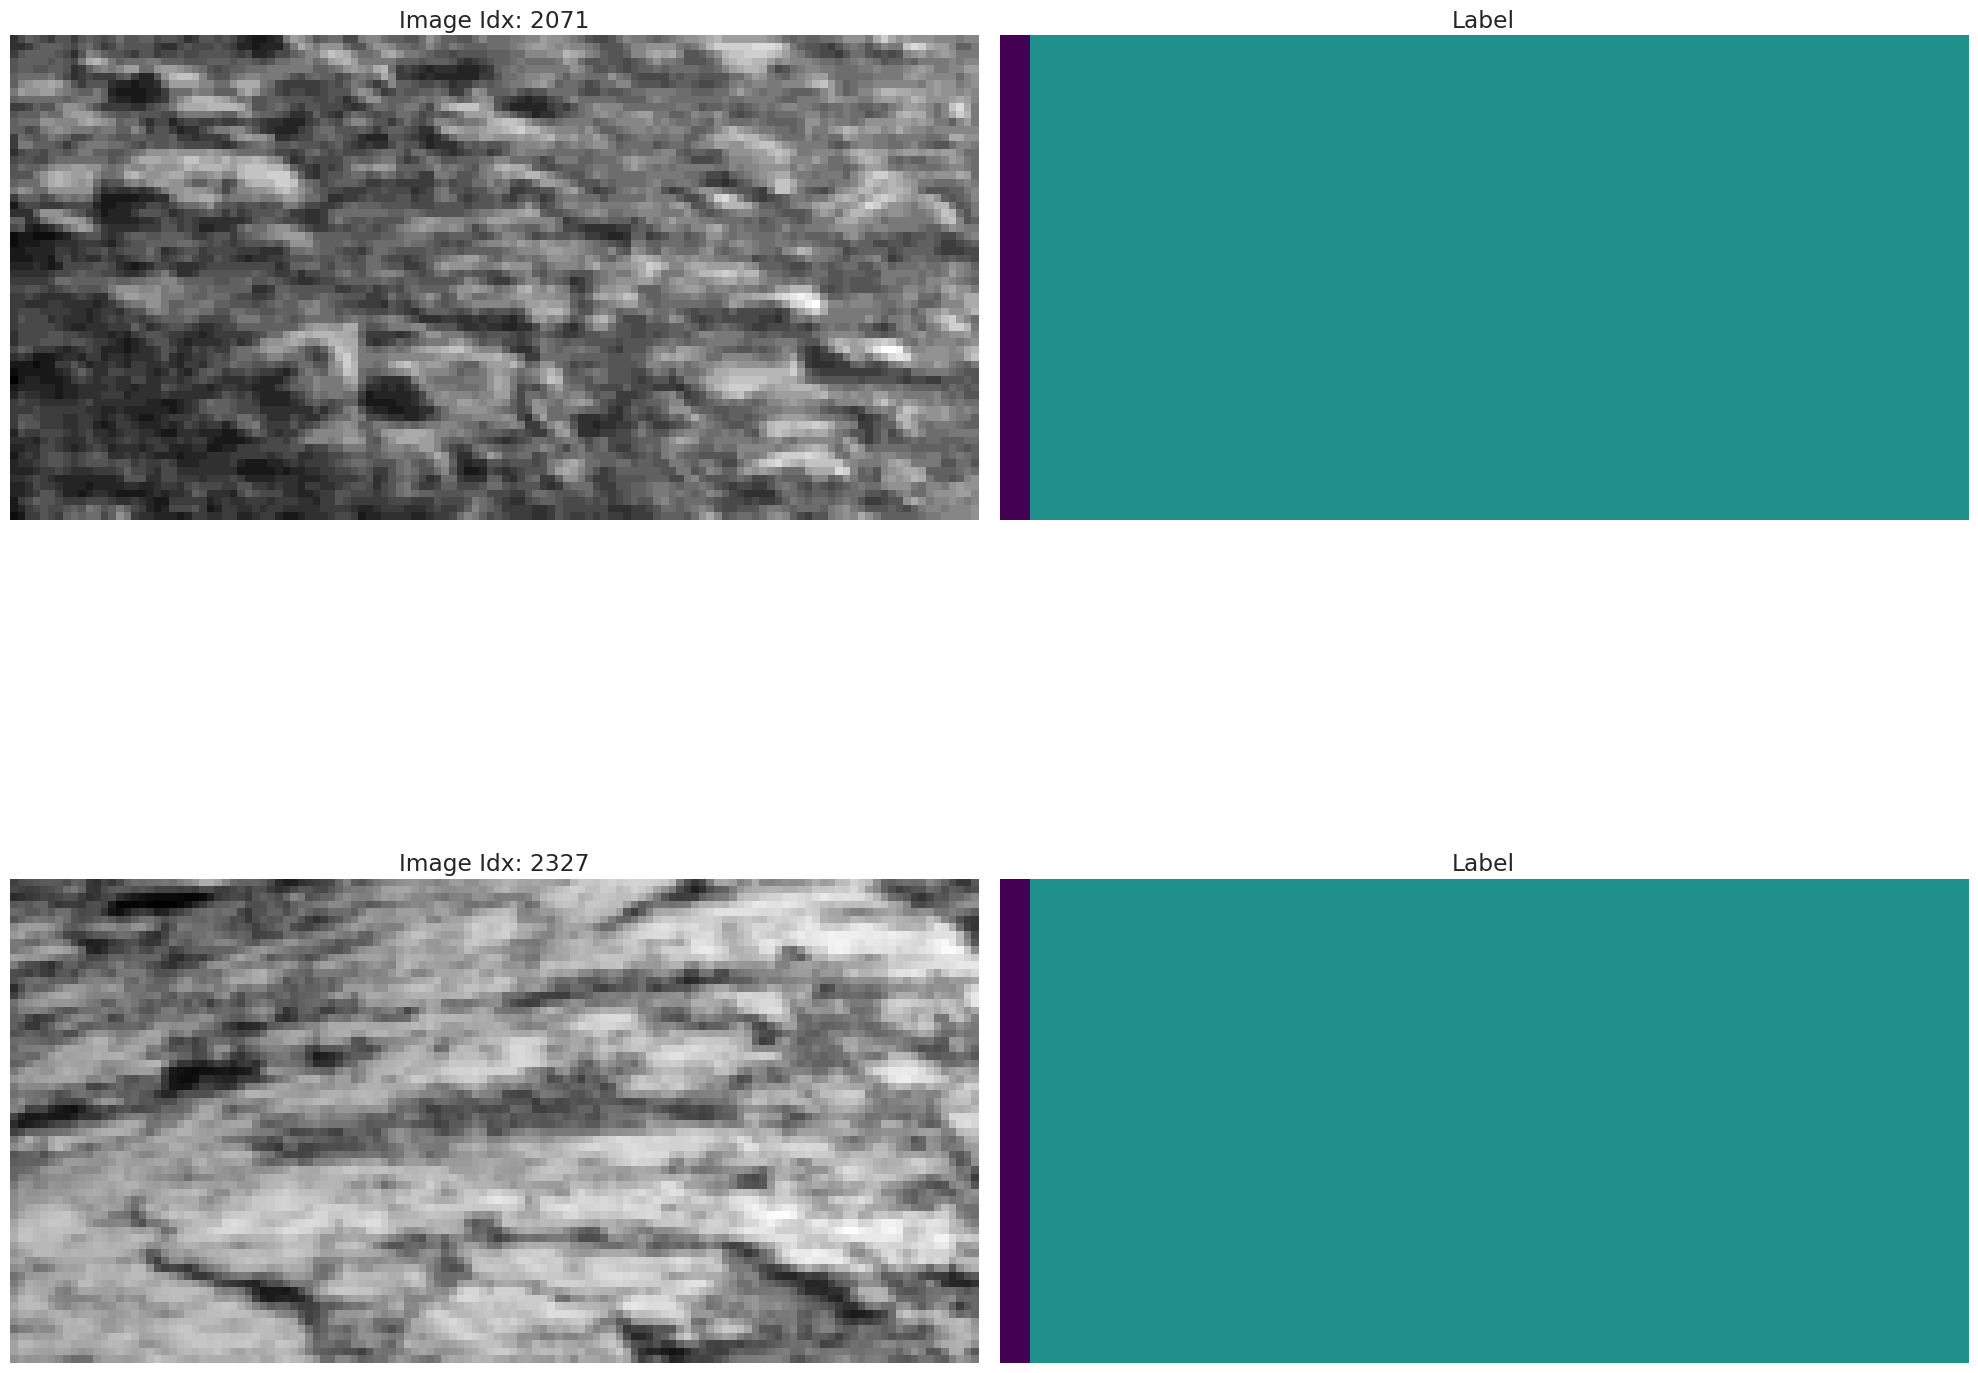

In [8]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')


    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [9]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## 🔄 Process Data

In [10]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## dividing in train and validaiton set

In [11]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [12]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


## normalizing the data

In [13]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.expand_dims(X, axis=-1)  
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0

    y = tf.expand_dims(y, axis=-1)
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

# preprocessing also the test set
X_test = X_test[..., np.newaxis] / 255.0

In [14]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

## defining augmentation

In [15]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


In [16]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
# Create the datasets
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


In [ ]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

Visualizing examples from the training set:


## 🛠️ Model Definition and Training

In [ ]:
# Conv2D Layer with BatchNorm and optional ReLU activation
@tf.keras.utils.register_keras_serializable()
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=3, padding="same", dilation=1, use_bias=False, activation=True):
        super().__init__()
        self.activation = activation
        self.conv = tfkl.Conv2D(out_channels, kernel_size, padding=padding, dilation_rate=dilation, use_bias=use_bias)
        self.bn = tfkl.BatchNormalization()
        self.relu = tfkl.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        if self.activation:
            x = self.relu(x)
        return x

# Squeeze-and-Excitation Block
@tf.keras.utils.register_keras_serializable()
class SqueezeExcitationBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, ratio=8):
        super().__init__()
        self.global_avg_pool = tfkl.GlobalAveragePooling2D()
        self.fc1 = tfkl.Dense(in_channels // ratio, activation="relu")
        self.fc2 = tfkl.Dense(in_channels, activation="softmax")

    def call(self, inputs):
        y = self.global_avg_pool(inputs)
        y = self.fc1(y)
        y = self.fc2(y)
        y = tf.reshape(y, (-1, 1, 1, inputs.shape[-1]))
        return inputs * y

# ASPP Module
@tf.keras.utils.register_keras_serializable()
class ASPP(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.avgpool = tfk.models.Sequential([
            tfkl.GlobalAveragePooling2D(),
            tfkl.Reshape((1, 1, in_channels)),
            Conv2D(out_channels, kernel_size=1, padding="valid")
        ])
        self.conv1 = Conv2D(out_channels, kernel_size=1, padding="valid")
        self.conv2 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=6)
        self.conv3 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=12)
        self.conv4 = Conv2D(out_channels, kernel_size=3, padding="same", dilation=18)
        self.final_conv = Conv2D(out_channels, kernel_size=1, padding="valid")
        self.match_channel = Conv2D(in_channels, kernel_size=1, padding="valid")

    def call(self, inputs):
        # reshaping input to match the desired deepth
        if(self.in_channels != inputs.shape[3]):
            inputs = self.match_channel(inputs)
       # print("x",inputs.shape) # PRINT !!!!!!!!!!!!!!!!!!
        x0 = self.avgpool(inputs)
        x0 = tf.image.resize(x0, tf.shape(inputs)[1:3], method="bilinear")
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        x4 = self.conv4(inputs)
        x_concat = tf.concat([x0, x1, x2, x3, x4], axis=-1)
        return self.final_conv(x_concat)

# Convolutional Block with SE block
@tf.keras.utils.register_keras_serializable()
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = Conv2D(out_channels)
        self.conv2 = Conv2D(out_channels)
        self.se_block = SqueezeExcitationBlock(out_channels)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.se_block(x)

### Encoder 1 (Res-Net style)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tfkl.Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = tfkl.Conv2D(filters, kernel_size, padding='same')
        self.add = tfkl.Add()
        self.activation = tfkl.ReLU()
        self.match_channels = tfkl.Conv2D(filters, 1, padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        # matching the sizes 
        if inputs.shape[-1] != x.shape[-1]:
            inputs = self.match_channels(inputs)
        
        x = self.add([x, inputs])  # Skip connection
        return self.activation(x)
        
@tf.keras.utils.register_keras_serializable()
class ResNetEncoder(tf.keras.layers.Layer):
    def __init__(self, filters=[32, 64, 128, 256], kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        self.conv1 = tfkl.Conv2D(filters[0], kernel_size, padding='same', activation='relu')
        self.res_blocks = [ResidualBlock(filters[i], kernel_size) for i in range(1, len(filters))]
        self.pool = tfkl.MaxPooling2D(pool_size=(2, 2), padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        skip_connections = [x]
        x = self.pool(x)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        for block in self.res_blocks:
            x = block(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            skip_connections.append(x)
            x = self.pool(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x, skip_connections[::-1]


In [ ]:
# Encoder2 Custom Implementation
@tf.keras.utils.register_keras_serializable()
class Encoder1(tf.keras.layers.Layer):
    def __init__(self, inputs=1, filters=[32,64,128,256], **kwargs):
        super().__init__(**kwargs)
        
        self.pool = tfkl.MaxPooling2D(pool_size=(2, 2))
        self.conv1 = ConvBlock(input, filters[0])
        self.convs = [ConvBlock(filters[i], filters[i+1]) for i in range(len(filters)-1)]

    def call(self, inputs):
        x = self.conv1(inputs)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        skip_connections = [x]
        x = self.pool(x)
        #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        for conv in self.convs:
            x = conv(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            skip_connections.append(x)
            x = self.pool(x)
            #print(x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x, skip_connections[::-1]



In [ ]:
# Decoder Block
@tf.keras.utils.register_keras_serializable()
class Decoder1(tf.keras.layers.Layer):
    def __init__(self, skip_channel_sizes):
        super().__init__()
        self.upsample = tfkl.UpSampling2D(size=(2, 2), interpolation="bilinear")
        self.blocks = [
            # skip_channel_sizes[i] + skip_channel_sizes[i + 1], skip_channel_sizes[i + 1] for i in range(len(skip_channel_sizes) - 1
            ConvBlock(skip_channel_sizes[i] * 2 , skip_channel_sizes[i]) for i in range(len(skip_channel_sizes))
        ]

    def call(self, x, skips):
        for skip, block in zip(skips, self.blocks):
            x = self.upsample(x)
            #print("up",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = tf.image.resize(x, tf.shape(skip)[1:3], method="bilinear")
            x = tf.concat([x, skip], axis=-1)
            #print("conc",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = block(x)
            #print("conv",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x

In [ ]:
# Decoder Block
@tf.keras.utils.register_keras_serializable()
class Decoder2(tf.keras.layers.Layer):
    def __init__(self, skip_channel_sizes):
        super().__init__()
        self.upsample = tfkl.UpSampling2D(size=(2, 2), interpolation="bilinear")
        self.blocks = [
            # skip_channel_sizes[i] + skip_channel_sizes[i + 1], skip_channel_sizes[i + 1] for i in range(len(skip_channel_sizes) - 1
            ConvBlock(skip_channel_sizes[i] * 2 , skip_channel_sizes[i]) for i in range(len(skip_channel_sizes))
        ]

    def call(self, x, skips_enc1, skips_enc2):
        for skip1, skip2, block in zip(skips_enc1, skips_enc2, self.blocks):
            x = self.upsample(x)
            #print("up",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = tf.image.resize(x, tf.shape(skip1)[1:3], method="bilinear")
            x = tf.concat([x, skip1,skip2], axis=-1)
            #print("conc",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
            x = block(x)
            #print("conv",x.shape) # PRINT !!!!!!!!!!!!!!!!!!
        return x

In [ ]:
# Double U-Net
def build_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    encoder1 = Encoder1(inputs=1, filters=[8,16,32,64]) # 32,64,128,256
    aspp1 = ASPP(128, 128) # 256, 256
    decoder1 = Decoder1([64, 32, 16, 8]) #64, 128, 256, 512
    y1 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name='output_layer')
    
    encoder2 = ResNetEncoder(filters=[64, 128, 256, 512]) # 32 -> 128
    aspp2 = ASPP(1024, 1024) # 256 -> 64
    decoder2 = Decoder2([512, 256, 128, 64]) #[64, 128, 256, 512]
    y2 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax")

    
    print("input", inputs.shape)
    x, skip1 = encoder1(inputs)
    print("enc1",x.shape)
    x = aspp1(x)
    print("aspp1",x.shape)
    x = decoder1(x, skip1)
    print("dec1",x.shape)
    y1 = y1(x)
    print("y1",y1.shape)
   
    multiplied = tfkl.Multiply()([inputs, y1])
    x, skip2 = encoder2(multiplied)
    print("enc2",x.shape)
    x = aspp2(x)
    print("aspp2",x.shape)
    x = decoder2(x, skip1, skip2)
    print("dec2",x.shape)
    y2 = y2(x)
    print("y2",y2.shape)

    # concatenates the outputs
    combined_outputs = tf.keras.layers.Concatenate(axis=-1)([y1, y2])  # Shape: (None, 64, 128, 10)
    output = tfkl.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(combined_outputs)  # Shape: (None, 64, 128, 5)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='DUNet')
    return model


input (None, 64, 128, 1)
enc1 (None, 4, 8, 64)
aspp1 (None, 4, 8, 128)
dec1 (None, 64, 128, 8)
y1 (None, 64, 128, 5)
enc2 (None, 4, 8, 512)
aspp2 (None, 4, 8, 1024)
dec2 (None, 64, 128, 64)
y2 (None, 64, 128, 5)


Model: "DUNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ encoder1          │ [(None, 4, 8,   │    75,679 │ input_layer[0… │   Y   │
│ (Encoder1)        │ 64), (None, 8,  │           │                │       │
│                   │ 16, 64), (None, │           │                │       │
│                   │ 16, 32, 32),    │           │                │       │
│                   │ (None, 32, 64,  │           │                │       │
│                   │ 16), (None, 64, │           │                │       │
│                   │ 128, 8)]        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ aspp (ASPP)       │ (None, 4, 8,    │   568,832 │ encoder1[0][0] │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ decoder1          │ (None, 64, 128, │   198,295 │ aspp[0][0],    │   Y   │
│ (Decoder1)        │ 8)              │           │ encoder1[0][1… │       │
│                   │                 │           │ encoder1[0][2… │       │
│                   │                 │           │ encoder1[0][3… │       │
│                   │                 │           │ encoder1[0][4] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ output_layer      │ (None, 64, 128, │        45 │ decoder1[0][0] │   Y   │
│ (Conv2D)          │ 5)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ multiply          │ (None, 64, 128, │         0 │ input_layer[0… │   -   │
│ (Multiply)        │ 5)              │           │ output_layer[… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res_net_encoder   │ [(None, 4, 8,   │ 4,822,528 │ multiply[0][0] │   Y   │
│ (ResNetEncoder)   │ 512), (None, 8, │           │                │       │
│                   │ 16, 512),       │           │                │       │
│                   │ (None, 16, 32,  │           │                │       │
│                   │ 256), (None,    │           │                │       │
│                   │ 32, 64, 128),   │           │                │       │
│                   │ (None, 64, 128, │           │                │       │
│                   │ 64)]            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ aspp_1 (ASPP)     │ (None, 4, 8,    │ 36,204,5… │ res_net_encod… │   Y   │
│                   │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ decoder2          │ (None, 64, 128, │ 13,021,2… │ aspp_1[0][0],  │   Y   │
│ (Decoder2)        │ 64)             │           │ encoder1[0][1… │       │
│                   │                 │           │ encoder1[0][2… │       │
│                   │                 │           │ encoder1[0][3… │       │
│                   │                 │           │ encoder1[0][4… │       │
│                   │                 │           │ res_net_encod… │       │
│                   │                 │           │ res_net_encod… │       │
│                   │                 │           │ res_net_encod… │       │
│                   │                 │           │ res_net_encod… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_86         │ (None, 64, 128, │       325 │ decoder2[0][0] │   Y 

 Total params: 54,891,543 (209.39 MB)

 Trainable params: 54,870,615 (209.31 MB)

 Non-trainable params: 20,928 (81.75 KB)

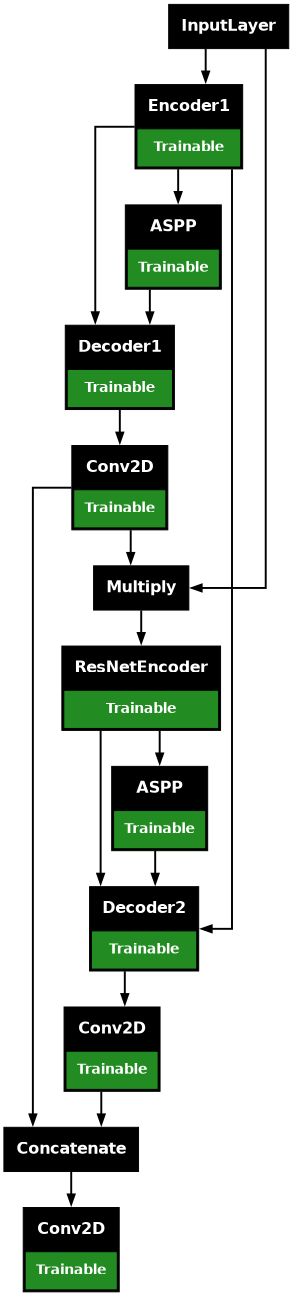

In [25]:
model = build_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [26]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                for i in range(2):
                    idx = 0 if i==0 else 14
                    image = image_batch[idx]  # Take the first image from the batch (oppure 13)
                    label = label_batch[idx]  # Take the first label from the batch
    
                    # Add batch dimension to the image (if necessary)
                    image = tf.expand_dims(image, 0)
    
                    # Perform prediction
                    pred = self.model.predict(image, verbose=0)
                    y_pred = tf.math.argmax(pred, axis=-1)
                    y_pred = y_pred.numpy()  # Convert to NumPy array for visualization
    
                    # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                    num_classes = NUM_CLASSES
                    colormap = create_segmentation_colormap(num_classes)
    
                    # Plot the results
                    plt.figure(figsize=(16, 4))
    
                    # Input image
                    plt.subplot(i+1, 3, 1)
                    plt.imshow(image[0], cmap='gray')
                    plt.title("Input Image")
                    plt.axis('off')
    
                    # Ground truth
                    plt.subplot(i+1, 3, 2)
                    colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                    plt.imshow(colored_label)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
    
                    # Prediction
                    plt.subplot(i+1, 3, 3)
                    colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                    plt.imshow(colored_pred)
                    plt.title("Predicted Mask")
                    plt.axis('off')

                    plt.tight_layout()
                plt.show()
                plt.close()

### class weights

In [27]:
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

class_weights[0] = 0 # adjusting class weight
class_weights[4] = 20
class_weights = dict(enumerate(class_weights)) 
print("Class weights:", class_weights)

Class weights: {0: 0.0, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 20.0}


#### Boundary Loss

In [28]:
# Boudary Loss as expose (SurfaceLoss) in https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py
# code related to https://arxiv.org/abs/1812.07032

class BoundaryLoss(tf.keras.losses.Loss):
    def __init__(self, idc, **kwargs):
        """
        Boundary Loss implementation in TensorFlow.
        Args:
            idc (List[int]): List of class indices to filter out in the target mask.
        """
        super().__init__(**kwargs)
        self.idc = idc  # Classes to exclude
        #print(f"Initialized {self.__class__.__name__} with idc={idc}")

    def call(self, probs, dist_maps):
        """
        Compute the boundary loss.
        Args:
            probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes, height, width).
            dist_maps (tf.Tensor): Distance maps, shape (batch_size, num_classes, height, width).
        
        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure the inputs are valid
        tf.debugging.assert_less_equal(tf.reduce_max(probs), 1.0, "Probs are not simplex (values > 1)")
        tf.debugging.assert_greater_equal(tf.reduce_min(probs), 0.0, "Probs are not simplex (values < 0)")

        # Exclude the specified classes
        all_classes = tf.range(probs.shape[1])  # All class indices
        include_classes = tf.boolean_mask(all_classes, ~tf.reduce_any(all_classes[..., None] == self.idc, axis=-1))

        # Select only the included classes
        pc = tf.gather(probs, include_classes, axis=1)
        dc = tf.gather(dist_maps, include_classes, axis=1)

        # Perform element-wise multiplication
        multiplied = tf.multiply(pc, dc)

        # Compute mean loss
        loss = multiplied

        return tf.reduce_mean(loss)

### Dice Loss

In [29]:
def dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes=[]):
    """
    Compute the Dice loss, excluding specific classes from the evaluation.

    Parameters:
    - y_true: Tensor of shape (batch_size, ..., num_classes), ground truth one-hot labels.
    - y_pred: Tensor of shape (batch_size, ..., num_classes), predicted probabilities.
    - excluded_classes: List of class indices to exclude from the loss computation.

    Returns:
    - Dice loss value, averaged over the included classes.
    """
    # Convert excluded_classes to a Tensor for proper indexing
    excluded_classes = tf.constant(excluded_classes, dtype=tf.int32)

    # Ensure y_pred values are between 0 and 1
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Compute numerator (intersection) and denominator for Dice coefficient
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions
    denominator = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions

    # Avoid division by zero
    dice_coeff = numerator / (denominator + 1e-7)

    # Create a mask to exclude specified classes
    mask = tf.ones_like(dice_coeff, dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(mask, tf.expand_dims(excluded_classes, axis=-1), tf.zeros_like(excluded_classes, dtype=tf.bool))

    # Apply mask to exclude classes
    included_dice_coeff = tf.boolean_mask(dice_coeff, mask)

    # Compute Dice loss as 1 - mean Dice coefficient of included classes
    dice_loss = 1 - tf.reduce_mean(included_dice_coeff)

    return dice_loss

### Dynamic multi-loss

In [30]:
excluded_classes = [0]
SCCE = tf.keras.losses.SparseCategoricalCrossentropy()
Boundary = BoundaryLoss(idc=excluded_classes)

'''
adjusts the weights based on the epoch number, 
reducing the Focal loss weight and increasing the Dice loss weight as training progresses.
'''

class DynamicLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DynamicLoss, self).__init__(**kwargs)
        self.initial_dice_weight = 0.4
        self.initial_scce_weight = 0.4
        self.initial_boundary_weight = 0.2
        
        self.scce_weight = self.initial_scce_weight
        self.dice_weight = self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight

    def update_weights(self, epoch):
        total_epochs = EPOCHS
        epoch_factor = epoch / total_epochs
        
        # Adjust weights dynamically
        self.scce_weight = self.initial_scce_weight + epoch_factor * (1 - self.initial_scce_weight)
        self.dice_weight = self.initial_dice_weight - epoch_factor * self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight + epoch_factor * (1 - self.initial_boundary_weight)
        
        # Normalize weights so they sum to 1
        total_weight = self.scce_weight +  self.dice_weight + self.boundary_weight
        self.scce_weight /= total_weight
        self.dice_weight /= total_weight
        self.boundary_weight /= total_weight

        print(f"SCCE weight: {self.scce_weight:.4f} - "
              f"dice weight: {self.dice_weight:.4f} - "
              f"boundary weight: {self.boundary_weight:.4f}")

    def call(self, y_true, y_pred):

        y_true = tf.cast(y_true, tf.int32)  # Make sure y_true is of type int32
        y_true = tf.squeeze(y_true, axis=-1)  # Remove any extra dimensions (like [batch_size, height, width, 1])
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # Convert to one-hot encoding
        y_true = tf.cast(y_true, tf.float32)
        
        # evaluating weights based on classes pixel by pixel, normalized
        class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())], dtype=tf.float32)

        sample_weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)

        # Calculate individual losses
        y_true_indices = tf.argmax(y_true, axis=-1) # sparse categorical cross entropy expect a y_true with y_prede_dim-1
        SCCE_value = SCCE(y_true_indices, y_pred, sample_weight=sample_weights)
        
        Dice_value = dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes)
        Boundary_value = Boundary(y_true, y_pred)

        # Combine losses
        total_loss = self.scce_weight * SCCE_value + self.dice_weight * Dice_value + self.boundary_weight * Boundary_value
        return tf.reduce_mean(total_loss)

In [31]:
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EpochTracker, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch 
        self.model.loss.update_weights(epoch)
        
    def get_epoch(self):
        return getattr(self, 'epoch', 0) 

In [32]:
# Compile the model
dynamic_loss = DynamicLoss()
# keep track of the epochs for the dynamic_loss updates
epoch_tracker = EpochTracker()

model.compile(
    loss=dynamic_loss, 
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [33]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=10, 
    min_delta=1e-5,
)

viz_callback = VizCallback(val_dataset, frequency=5)

SCCE weight: 0.4000 - dice weight: 0.4000 - boundary weight: 0.2000
Epoch 1/200


I0000 00:00:1734086824.895041      76 service.cc:145] XLA service 0x7bc6b002e340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734086824.895127      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734086824.895133      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734086832.417065      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734086832.419726      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734086832.422507      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1734087220.686074      76 device_compiler.h:188] Comp

31/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.2623 - loss: 0.7547 - mean_iou: 0.0291

W0000 00:00:1734087282.059653      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734087282.061237      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734087282.062834      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2621 - loss: 0.7547 - mean_iou: 0.0299

W0000 00:00:1734087454.166179      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734087454.168883      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734087454.172264      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1734087465.998354      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734087465.999908      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734087466.001357      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynami

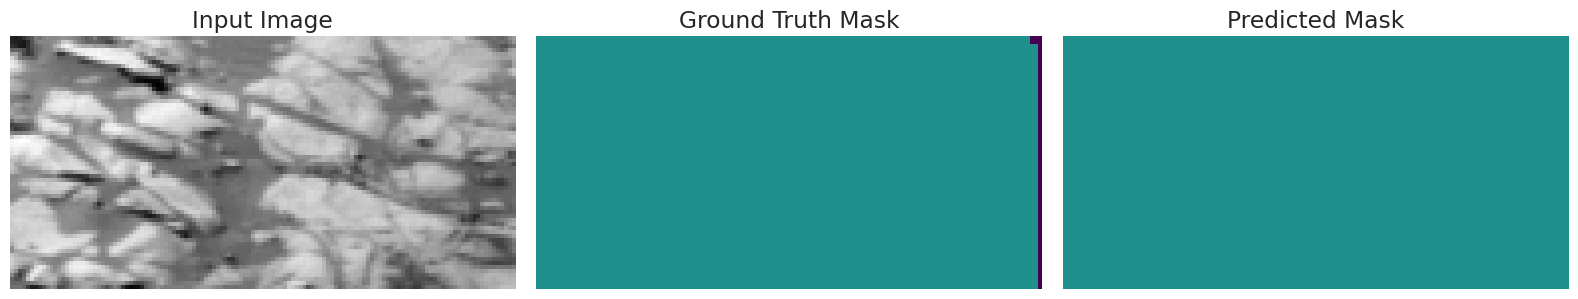

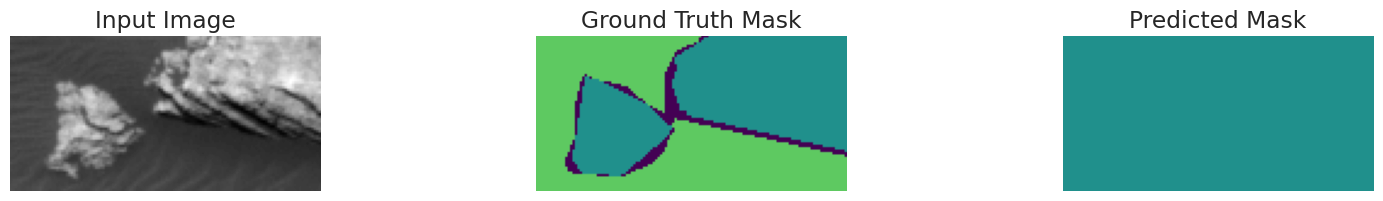

32/32 ━━━━━━━━━━━━━━━━━━━━ 739s 10s/step - accuracy: 0.2619 - loss: 0.7547 - mean_iou: 0.0307 - val_accuracy: 0.2076 - val_loss: 0.7539 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4010 - dice weight: 0.3960 - boundary weight: 0.2030
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2304 - loss: 0.7293 - mean_iou: 0.0827 - val_accuracy: 0.2076 - val_loss: 0.7356 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4020 - dice weight: 0.3921 - boundary weight: 0.2059
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2921 - loss: 0.7012 - mean_iou: 0.1703 - val_accuracy: 0.2076 - val_loss: 0.7207 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4030 - dice weight: 0.3882 - boundary weight: 0.2089
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3809 - loss: 0.6736 - mean_iou: 0.2758 - val_accuracy: 0.2076 - val_loss: 0.7088 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4039 - dice weight:

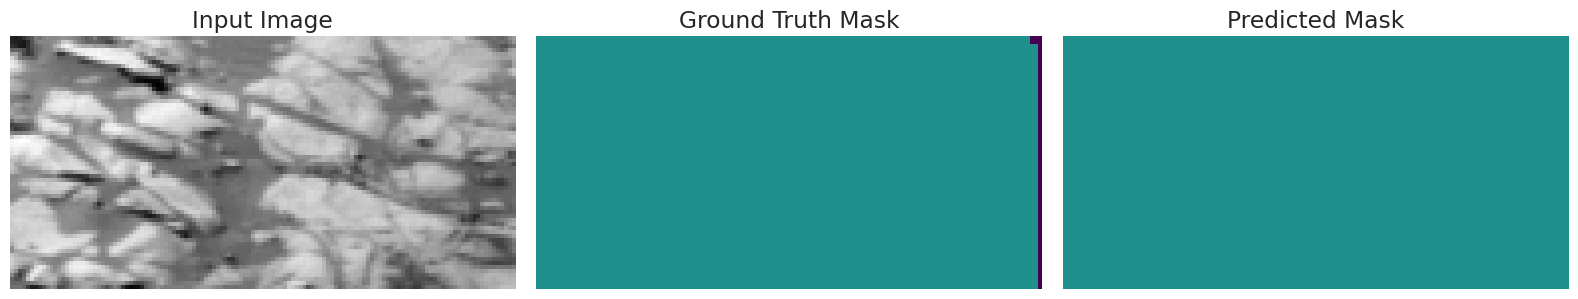

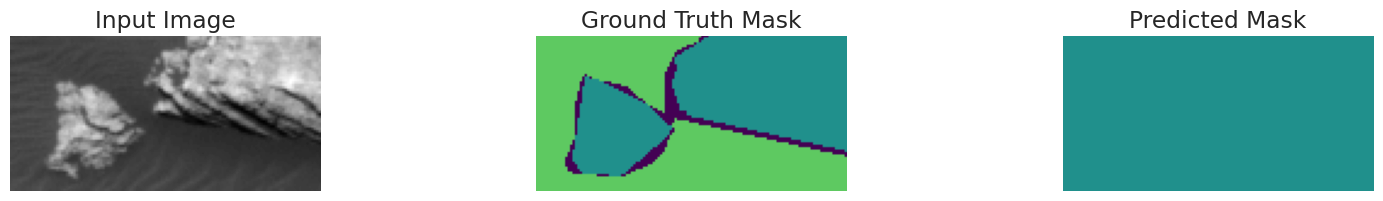

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5071 - loss: 0.6291 - mean_iou: 0.4048 - val_accuracy: 0.2076 - val_loss: 0.6922 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4058 - dice weight: 0.3767 - boundary weight: 0.2175
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5075 - loss: 0.6055 - mean_iou: 0.4004 - val_accuracy: 0.2076 - val_loss: 0.6829 - val_mean_iou: 0.0688 - learning_rate: 0.0010
SCCE weight: 0.4068 - dice weight: 0.3729 - boundary weight: 0.2203
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5139 - loss: 0.5893 - mean_iou: 0.4021 - val_accuracy: 0.2102 - val_loss: 0.6751 - val_mean_iou: 0.0725 - learning_rate: 0.0010
SCCE weight: 0.4077 - dice weight: 0.3692 - boundary weight: 0.2231
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5338 - loss: 0.5730 - mean_iou: 0.4203 - val_accuracy: 0.2839 - val_loss: 0.6759 - val_mean_iou: 0.1366 - learning_rate: 0.0010
SCCE weight: 0.4086 - dice weight: 0

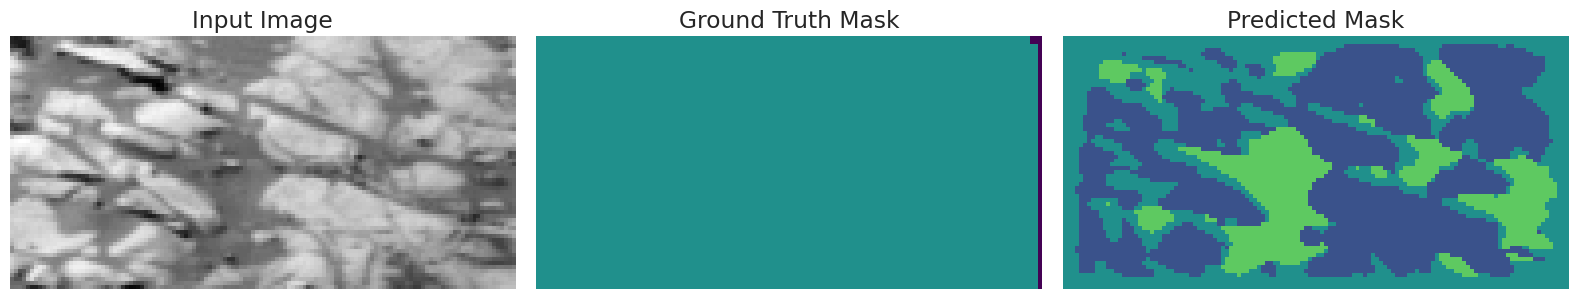

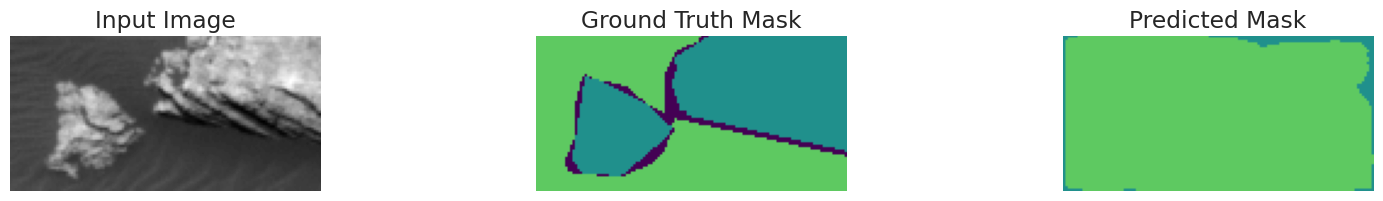

32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5469 - loss: 0.5564 - mean_iou: 0.4324 - val_accuracy: 0.3445 - val_loss: 0.6418 - val_mean_iou: 0.2003 - learning_rate: 0.0010
SCCE weight: 0.4104 - dice weight: 0.3583 - boundary weight: 0.2313
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5930 - loss: 0.5238 - mean_iou: 0.5039 - val_accuracy: 0.2084 - val_loss: 0.6624 - val_mean_iou: 0.0806 - learning_rate: 0.0010
SCCE weight: 0.4113 - dice weight: 0.3547 - boundary weight: 0.2340
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5952 - loss: 0.5116 - mean_iou: 0.5074 - val_accuracy: 0.2277 - val_loss: 0.6539 - val_mean_iou: 0.0998 - learning_rate: 0.0010
SCCE weight: 0.4122 - dice weight: 0.3512 - boundary weight: 0.2366
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5384 - loss: 0.5199 - mean_iou: 0.4406 - val_accuracy: 0.2182 - val_loss: 0.6953 - val_mean_iou: 0.0850 - learning_rate: 0.0010
SCCE weight: 0.4131 - dice weight

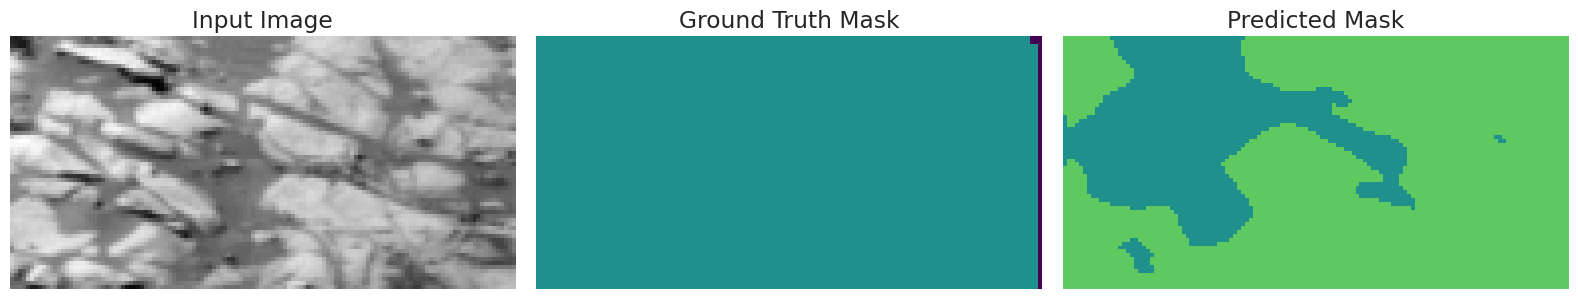

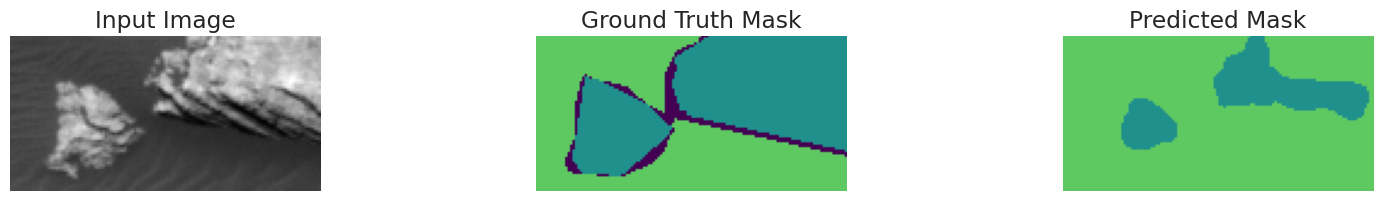

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5999 - loss: 0.4878 - mean_iou: 0.5151 - val_accuracy: 0.3289 - val_loss: 0.6321 - val_mean_iou: 0.1953 - learning_rate: 0.0010
SCCE weight: 0.4148 - dice weight: 0.3407 - boundary weight: 0.2444
Epoch 17/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5730 - loss: 0.4976 - mean_iou: 0.4709 - val_accuracy: 0.2022 - val_loss: 0.6525 - val_mean_iou: 0.0713 - learning_rate: 0.0010
SCCE weight: 0.4157 - dice weight: 0.3373 - boundary weight: 0.2470
Epoch 18/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6057 - loss: 0.4681 - mean_iou: 0.5227 - val_accuracy: 0.2392 - val_loss: 0.6366 - val_mean_iou: 0.1171 - learning_rate: 0.0010
SCCE weight: 0.4165 - dice weight: 0.3339 - boundary weight: 0.2495
Epoch 19/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5993 - loss: 0.4612 - mean_iou: 0.5121 - val_accuracy: 0.4644 - val_loss: 0.5261 - val_mean_iou: 0.3198 - learning_rate: 0.0010
SCCE weight: 0.4174 - dice weight

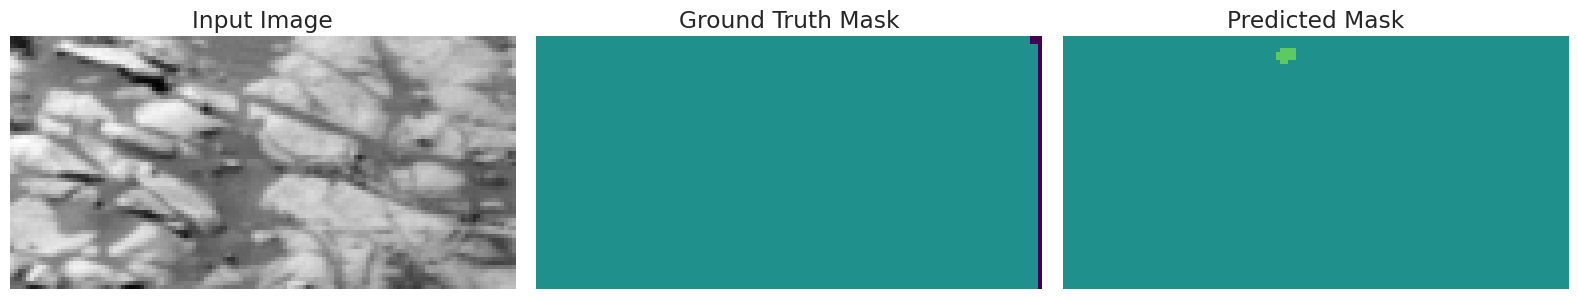

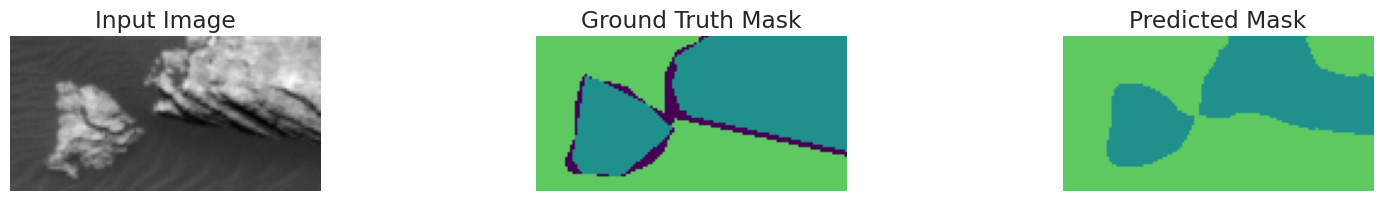

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6156 - loss: 0.4349 - mean_iou: 0.5417 - val_accuracy: 0.5606 - val_loss: 0.4743 - val_mean_iou: 0.4297 - learning_rate: 0.0010
SCCE weight: 0.4190 - dice weight: 0.3240 - boundary weight: 0.2570
Epoch 22/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6120 - loss: 0.4293 - mean_iou: 0.5385 - val_accuracy: 0.4392 - val_loss: 0.5412 - val_mean_iou: 0.3077 - learning_rate: 0.0010
SCCE weight: 0.4198 - dice weight: 0.3207 - boundary weight: 0.2595
Epoch 23/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6173 - loss: 0.4230 - mean_iou: 0.5387 - val_accuracy: 0.4942 - val_loss: 0.4928 - val_mean_iou: 0.3750 - learning_rate: 0.0010
SCCE weight: 0.4206 - dice weight: 0.3175 - boundary weight: 0.2619
Epoch 24/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6275 - loss: 0.4103 - mean_iou: 0.5569 - val_accuracy: 0.6074 - val_loss: 0.4295 - val_mean_iou: 0.5059 - learning_rate: 0.0010
SCCE weight: 0.4214 - dice weight

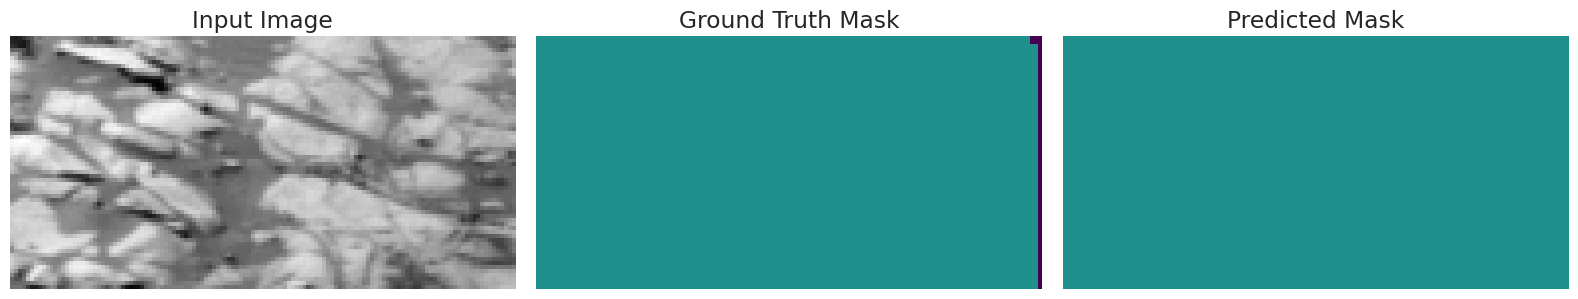

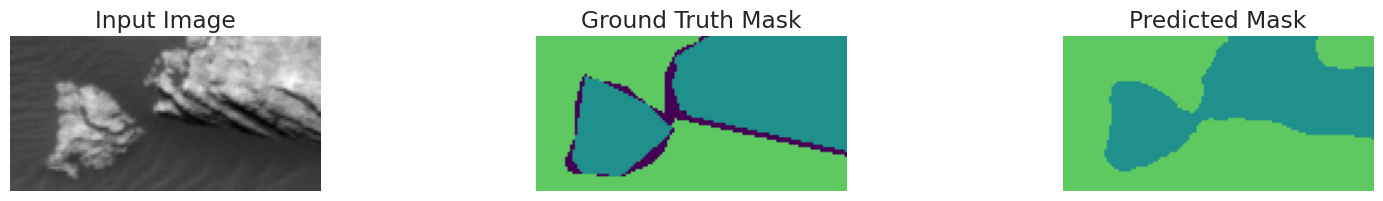

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6379 - loss: 0.3936 - mean_iou: 0.5672 - val_accuracy: 0.6181 - val_loss: 0.4110 - val_mean_iou: 0.5166 - learning_rate: 0.0010
SCCE weight: 0.4230 - dice weight: 0.3080 - boundary weight: 0.2690
Epoch 27/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6197 - loss: 0.3959 - mean_iou: 0.5493 - val_accuracy: 0.5875 - val_loss: 0.4256 - val_mean_iou: 0.4831 - learning_rate: 0.0010
SCCE weight: 0.4238 - dice weight: 0.3048 - boundary weight: 0.2714
Epoch 28/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6285 - loss: 0.3913 - mean_iou: 0.5591 - val_accuracy: 0.6209 - val_loss: 0.4135 - val_mean_iou: 0.5224 - learning_rate: 0.0010
SCCE weight: 0.4246 - dice weight: 0.3018 - boundary weight: 0.2737
Epoch 29/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6205 - loss: 0.3954 - mean_iou: 0.5422 - val_accuracy: 0.4941 - val_loss: 0.5390 - val_mean_iou: 0.3276 - learning_rate: 0.0010
SCCE weight: 0.4253 - dice weight

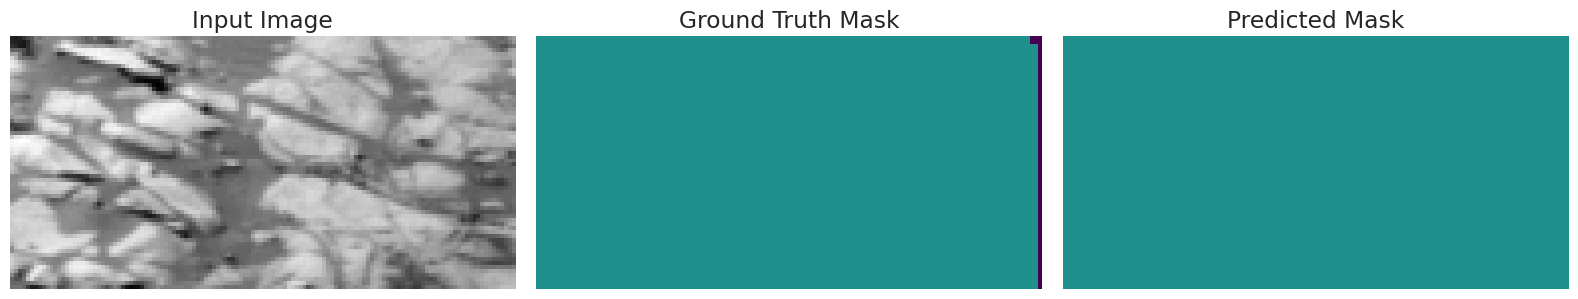

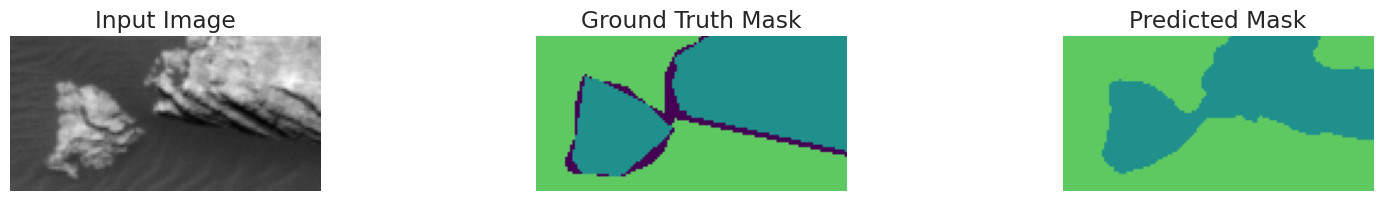

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6236 - loss: 0.3869 - mean_iou: 0.5510 - val_accuracy: 0.6306 - val_loss: 0.3922 - val_mean_iou: 0.5331 - learning_rate: 0.0010
SCCE weight: 0.4268 - dice weight: 0.2926 - boundary weight: 0.2805
Epoch 32/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6329 - loss: 0.3740 - mean_iou: 0.5545 - val_accuracy: 0.6434 - val_loss: 0.3814 - val_mean_iou: 0.5535 - learning_rate: 0.0010
SCCE weight: 0.4276 - dice weight: 0.2897 - boundary weight: 0.2828
Epoch 33/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6383 - loss: 0.3731 - mean_iou: 0.5627 - val_accuracy: 0.6396 - val_loss: 0.3991 - val_mean_iou: 0.5452 - learning_rate: 0.0010
SCCE weight: 0.4283 - dice weight: 0.2867 - boundary weight: 0.2850
Epoch 34/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6305 - loss: 0.3715 - mean_iou: 0.5627 - val_accuracy: 0.5916 - val_loss: 0.4327 - val_mean_iou: 0.4706 - learning_rate: 0.0010
SCCE weight: 0.4291 - dice weight

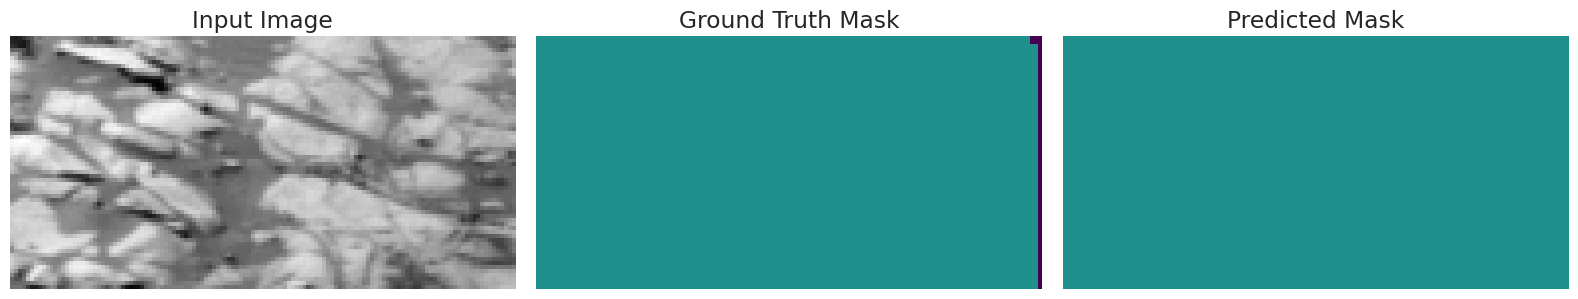

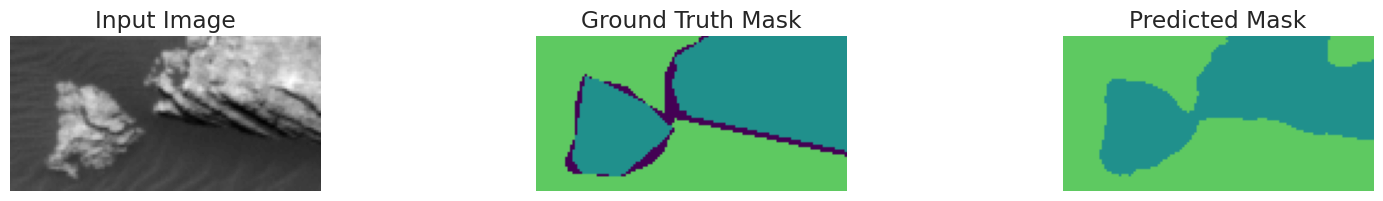

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6413 - loss: 0.3609 - mean_iou: 0.5700 - val_accuracy: 0.6436 - val_loss: 0.3644 - val_mean_iou: 0.5575 - learning_rate: 0.0010
SCCE weight: 0.4305 - dice weight: 0.2780 - boundary weight: 0.2915
Epoch 37/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6468 - loss: 0.3578 - mean_iou: 0.5856 - val_accuracy: 0.6227 - val_loss: 0.3897 - val_mean_iou: 0.5217 - learning_rate: 0.0010
SCCE weight: 0.4312 - dice weight: 0.2751 - boundary weight: 0.2937
Epoch 38/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6348 - loss: 0.3624 - mean_iou: 0.5651 - val_accuracy: 0.6413 - val_loss: 0.3747 - val_mean_iou: 0.5500 - learning_rate: 0.0010
SCCE weight: 0.4319 - dice weight: 0.2723 - boundary weight: 0.2958
Epoch 39/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6419 - loss: 0.3601 - mean_iou: 0.5738 - val_accuracy: 0.6334 - val_loss: 0.3721 - val_mean_iou: 0.5423 - learning_rate: 0.0010
SCCE weight: 0.4326 - dice weight

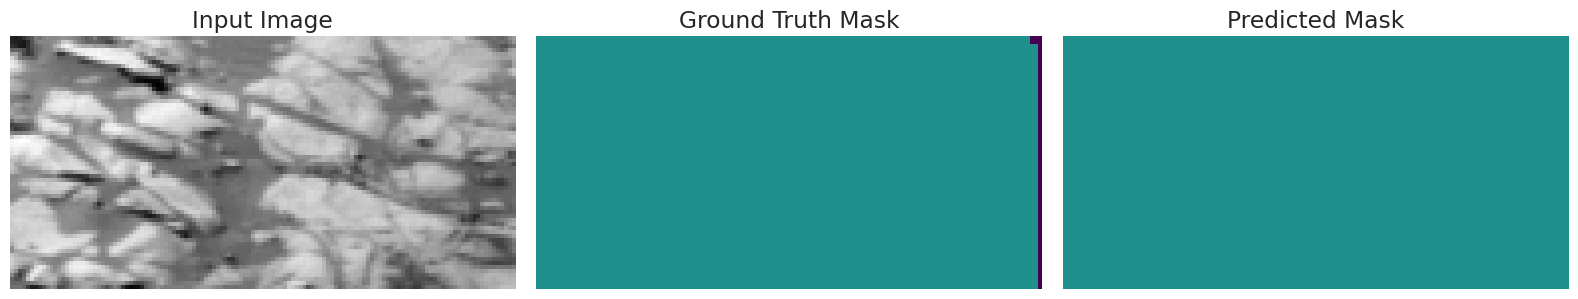

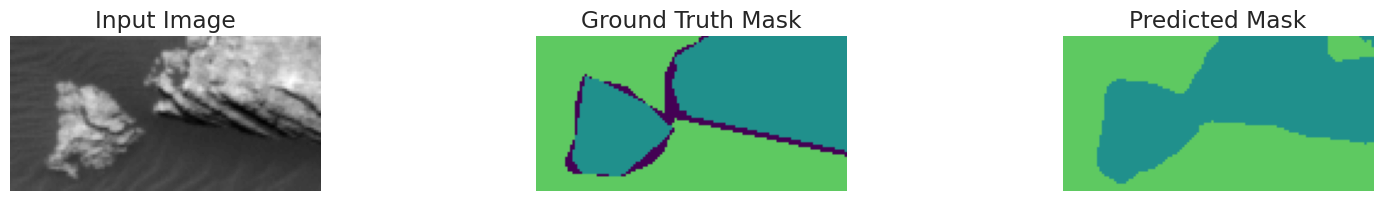

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6458 - loss: 0.3537 - mean_iou: 0.5828 - val_accuracy: 0.4965 - val_loss: 0.5002 - val_mean_iou: 0.3761 - learning_rate: 0.0010
SCCE weight: 0.4340 - dice weight: 0.2639 - boundary weight: 0.3021
Epoch 42/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6503 - loss: 0.3481 - mean_iou: 0.5873 - val_accuracy: 0.5812 - val_loss: 0.4148 - val_mean_iou: 0.4807 - learning_rate: 0.0010
SCCE weight: 0.4347 - dice weight: 0.2612 - boundary weight: 0.3041
Epoch 43/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6481 - loss: 0.3517 - mean_iou: 0.5824 - val_accuracy: 0.4455 - val_loss: 0.5408 - val_mean_iou: 0.3247 - learning_rate: 0.0010
SCCE weight: 0.4354 - dice weight: 0.2584 - boundary weight: 0.3062
Epoch 44/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6478 - loss: 0.3494 - mean_iou: 0.5821 - val_accuracy: 0.6234 - val_loss: 0.3740 - val_mean_iou: 0.5301 - learning_rate: 0.0010
SCCE weight: 0.4361 - dice weight

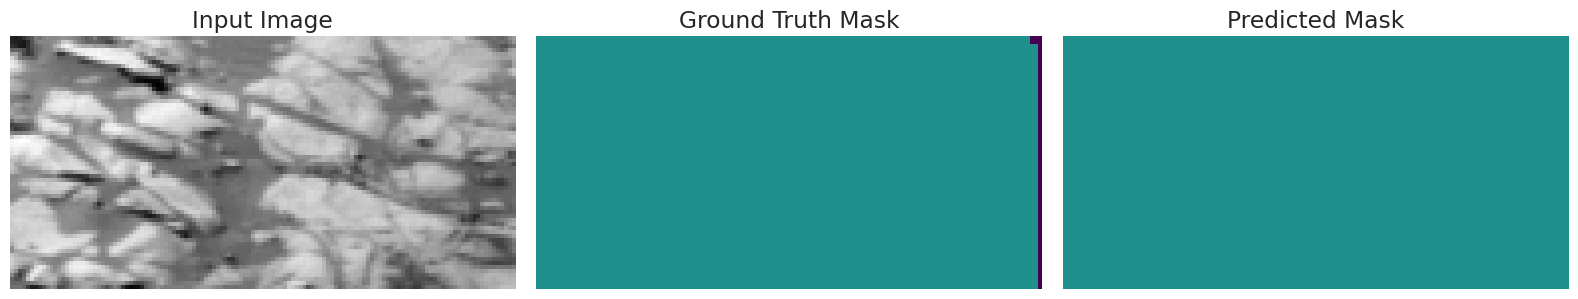

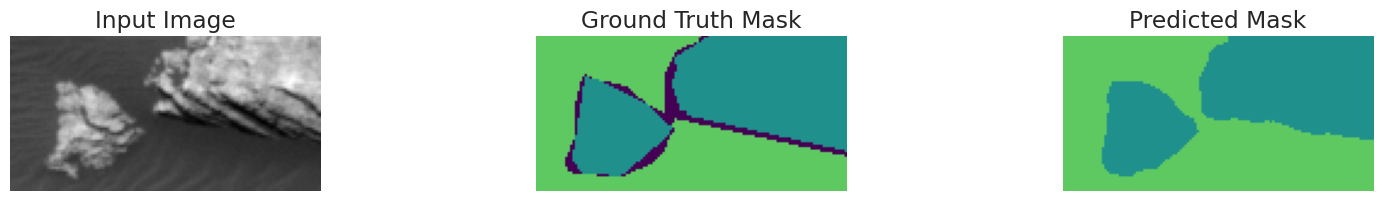

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6569 - loss: 0.3372 - mean_iou: 0.5991 - val_accuracy: 0.6524 - val_loss: 0.3523 - val_mean_iou: 0.5690 - learning_rate: 0.0010
SCCE weight: 0.4374 - dice weight: 0.2504 - boundary weight: 0.3122
Epoch 47/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6461 - loss: 0.3420 - mean_iou: 0.5948 - val_accuracy: 0.5021 - val_loss: 0.4771 - val_mean_iou: 0.3887 - learning_rate: 0.0010
SCCE weight: 0.4381 - dice weight: 0.2478 - boundary weight: 0.3142
Epoch 48/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6504 - loss: 0.3414 - mean_iou: 0.5880 - val_accuracy: 0.5630 - val_loss: 0.4177 - val_mean_iou: 0.4647 - learning_rate: 0.0010
SCCE weight: 0.4387 - dice weight: 0.2452 - boundary weight: 0.3161
Epoch 49/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6704 - loss: 0.3228 - mean_iou: 0.6178 - val_accuracy: 0.6398 - val_loss: 0.3597 - val_mean_iou: 0.5493 - learning_rate: 0.0010
SCCE weight: 0.4394 - dice weight

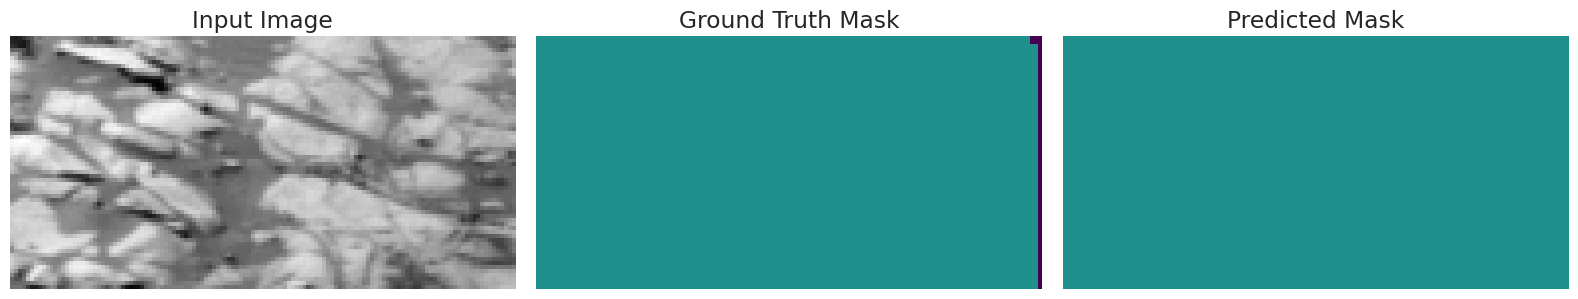

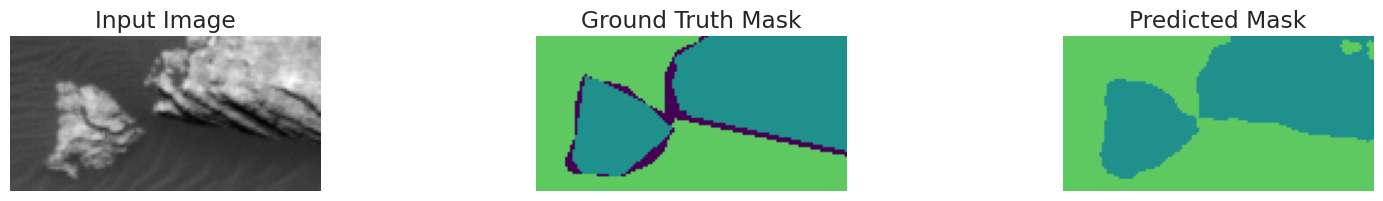

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6654 - loss: 0.3255 - mean_iou: 0.6104 - val_accuracy: 0.6662 - val_loss: 0.3378 - val_mean_iou: 0.5887 - learning_rate: 0.0010
SCCE weight: 0.4406 - dice weight: 0.2375 - boundary weight: 0.3219
Epoch 52/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6630 - loss: 0.3198 - mean_iou: 0.6137 - val_accuracy: 0.6377 - val_loss: 0.3655 - val_mean_iou: 0.5470 - learning_rate: 0.0010
SCCE weight: 0.4413 - dice weight: 0.2349 - boundary weight: 0.3238
Epoch 53/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6649 - loss: 0.3218 - mean_iou: 0.6108 - val_accuracy: 0.6591 - val_loss: 0.3381 - val_mean_iou: 0.5787 - learning_rate: 0.0010
SCCE weight: 0.4419 - dice weight: 0.2324 - boundary weight: 0.3257
Epoch 54/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6694 - loss: 0.3153 - mean_iou: 0.6118 - val_accuracy: 0.5894 - val_loss: 0.3874 - val_mean_iou: 0.4916 - learning_rate: 0.0010
SCCE weight: 0.4425 - dice weight

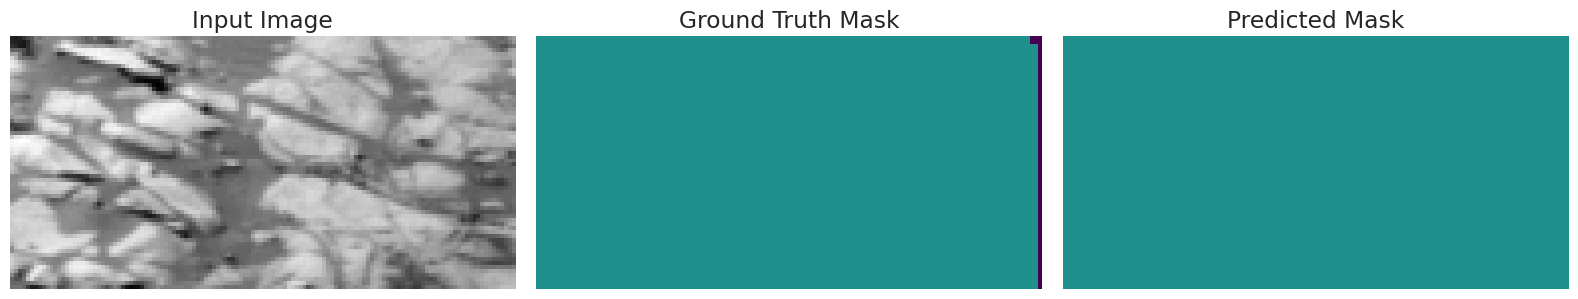

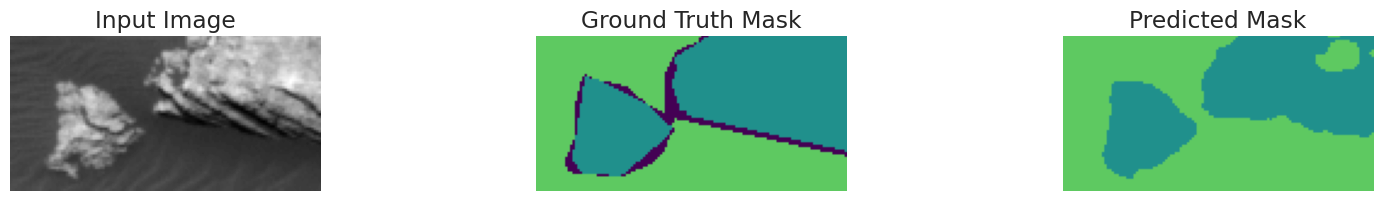

32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6632 - loss: 0.3208 - mean_iou: 0.6083 - val_accuracy: 0.6371 - val_loss: 0.3534 - val_mean_iou: 0.5476 - learning_rate: 0.0010
SCCE weight: 0.4437 - dice weight: 0.2250 - boundary weight: 0.3312
Epoch 57/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6660 - loss: 0.3131 - mean_iou: 0.6133 - val_accuracy: 0.5283 - val_loss: 0.4712 - val_mean_iou: 0.4169 - learning_rate: 0.0010
SCCE weight: 0.4444 - dice weight: 0.2226 - boundary weight: 0.3331
Epoch 58/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6587 - loss: 0.3240 - mean_iou: 0.6060 - val_accuracy: 0.5779 - val_loss: 0.4039 - val_mean_iou: 0.4714 - learning_rate: 0.0010
SCCE weight: 0.4450 - dice weight: 0.2202 - boundary weight: 0.3349
Epoch 59/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6731 - loss: 0.3126 - mean_iou: 0.6220 - val_accuracy: 0.5847 - val_loss: 0.4029 - val_mean_iou: 0.4758 - learning_rate: 0.0010
SCCE weight: 0.4456 - dice weight

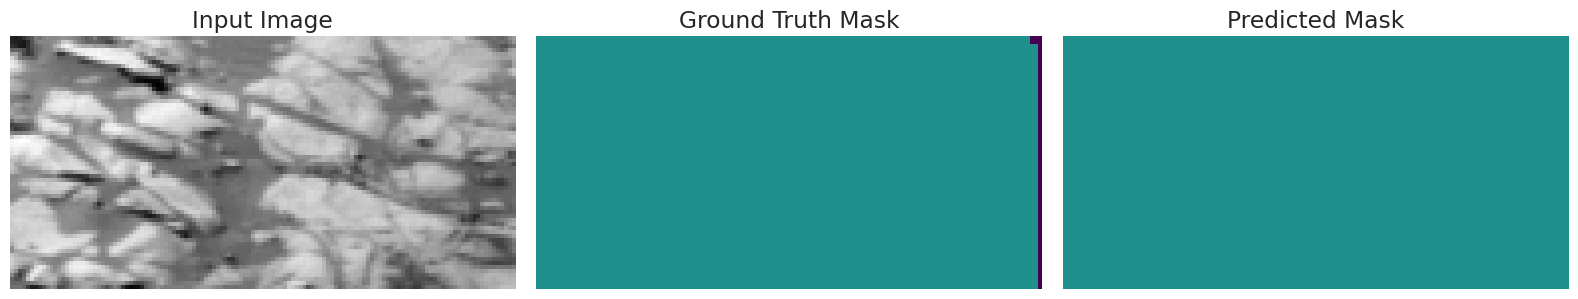

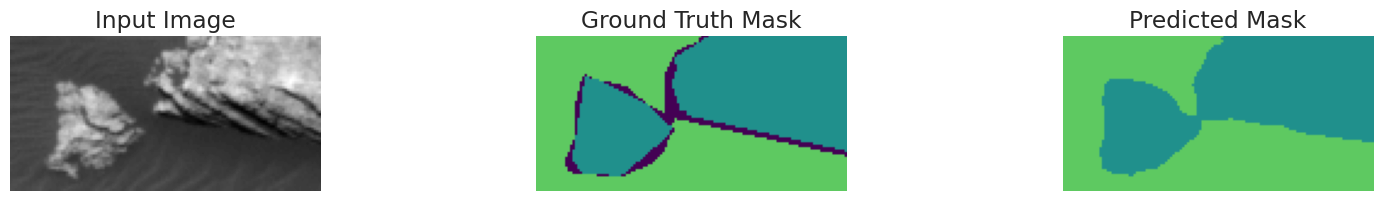

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6608 - loss: 0.3224 - mean_iou: 0.6070 - val_accuracy: 0.6607 - val_loss: 0.3487 - val_mean_iou: 0.5784 - learning_rate: 0.0010
SCCE weight: 0.4467 - dice weight: 0.2130 - boundary weight: 0.3402
Epoch 62/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6740 - loss: 0.3035 - mean_iou: 0.6215 - val_accuracy: 0.6670 - val_loss: 0.3387 - val_mean_iou: 0.5884 - learning_rate: 1.0000e-04
SCCE weight: 0.4473 - dice weight: 0.2107 - boundary weight: 0.3420
Epoch 63/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6827 - loss: 0.2972 - mean_iou: 0.6409 - val_accuracy: 0.6660 - val_loss: 0.3331 - val_mean_iou: 0.5870 - learning_rate: 1.0000e-04
SCCE weight: 0.4479 - dice weight: 0.2084 - boundary weight: 0.3437
Epoch 64/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6833 - loss: 0.2964 - mean_iou: 0.6474 - val_accuracy: 0.6749 - val_loss: 0.3233 - val_mean_iou: 0.6018 - learning_rate: 1.0000e-04
SCCE weight: 0.4485 -

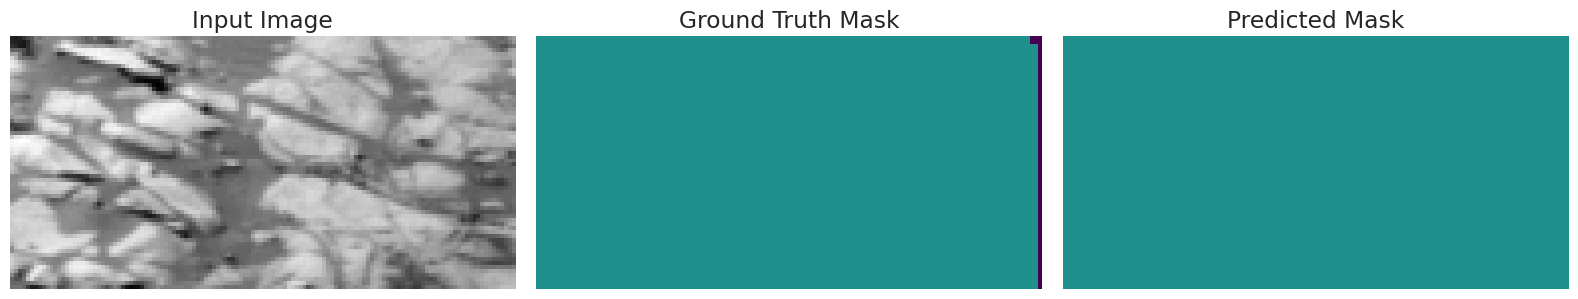

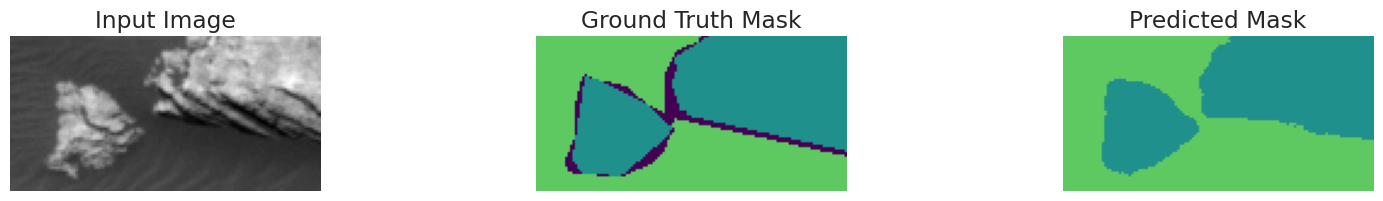

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6857 - loss: 0.2944 - mean_iou: 0.6459 - val_accuracy: 0.6752 - val_loss: 0.3238 - val_mean_iou: 0.6019 - learning_rate: 1.0000e-04
SCCE weight: 0.4496 - dice weight: 0.2015 - boundary weight: 0.3489
Epoch 67/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6829 - loss: 0.3001 - mean_iou: 0.6417 - val_accuracy: 0.6742 - val_loss: 0.3246 - val_mean_iou: 0.6003 - learning_rate: 1.0000e-04
SCCE weight: 0.4502 - dice weight: 0.1993 - boundary weight: 0.3506
Epoch 68/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6900 - loss: 0.2901 - mean_iou: 0.6530 - val_accuracy: 0.6763 - val_loss: 0.3207 - val_mean_iou: 0.6041 - learning_rate: 1.0000e-04
SCCE weight: 0.4507 - dice weight: 0.1970 - boundary weight: 0.3522
Epoch 69/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6840 - loss: 0.2944 - mean_iou: 0.6439 - val_accuracy: 0.6773 - val_loss: 0.3235 - val_mean_iou: 0.6055 - learning_rate: 1.0000e-04
SCCE weight: 0.45

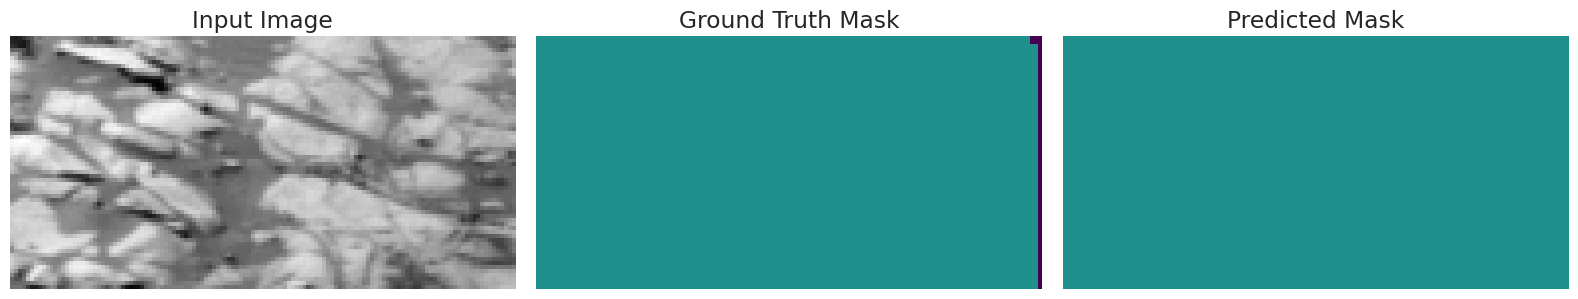

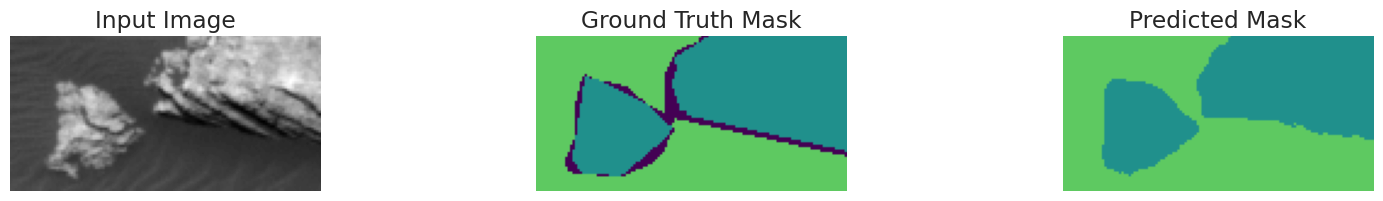

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6795 - loss: 0.2976 - mean_iou: 0.6398 - val_accuracy: 0.6770 - val_loss: 0.3220 - val_mean_iou: 0.6052 - learning_rate: 1.0000e-04
SCCE weight: 0.4524 - dice weight: 0.1904 - boundary weight: 0.3572
Epoch 72/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6883 - loss: 0.2907 - mean_iou: 0.6494 - val_accuracy: 0.6756 - val_loss: 0.3226 - val_mean_iou: 0.6019 - learning_rate: 1.0000e-04
SCCE weight: 0.4529 - dice weight: 0.1882 - boundary weight: 0.3588
Epoch 73/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6861 - loss: 0.2911 - mean_iou: 0.6421 - val_accuracy: 0.6761 - val_loss: 0.3223 - val_mean_iou: 0.6032 - learning_rate: 1.0000e-04
SCCE weight: 0.4535 - dice weight: 0.1861 - boundary weight: 0.3604
Epoch 74/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6850 - loss: 0.2923 - mean_iou: 0.6451 - val_accuracy: 0.6764 - val_loss: 0.3233 - val_mean_iou: 0.6034 - learning_rate: 1.0000e-04
SCCE weight: 0.45

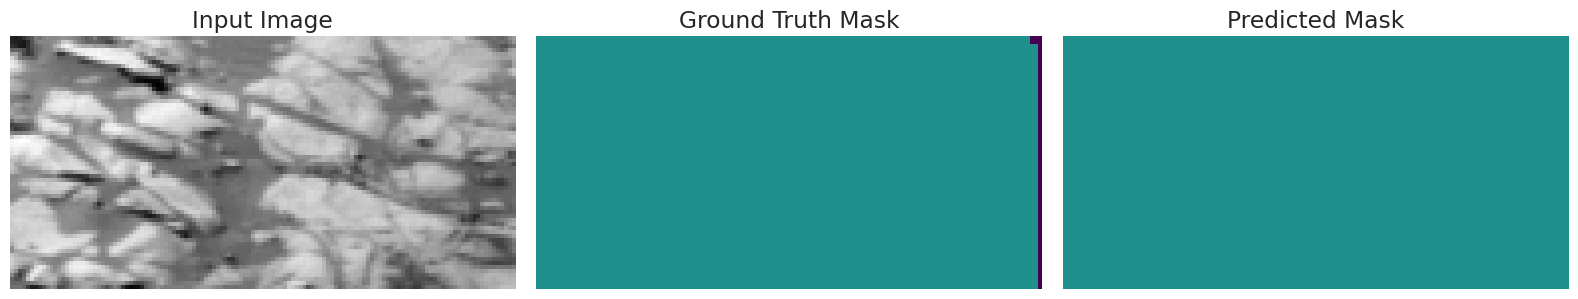

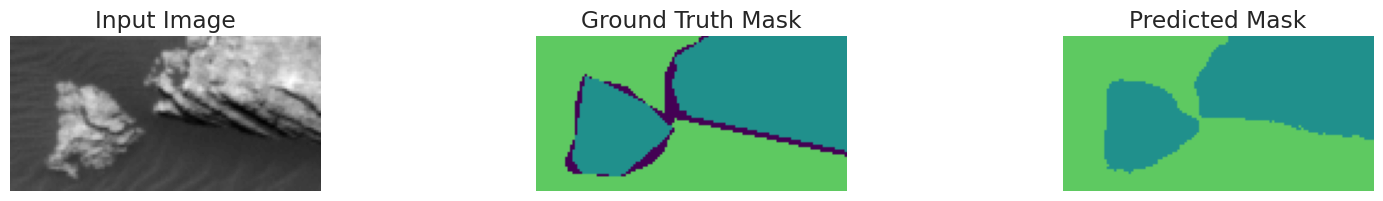

32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6881 - loss: 0.2861 - mean_iou: 0.6535 - val_accuracy: 0.6759 - val_loss: 0.3228 - val_mean_iou: 0.6030 - learning_rate: 1.0000e-04
SCCE weight: 0.4551 - dice weight: 0.1797 - boundary weight: 0.3652
Epoch 77/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6815 - loss: 0.2904 - mean_iou: 0.6384 - val_accuracy: 0.6719 - val_loss: 0.3261 - val_mean_iou: 0.5961 - learning_rate: 1.0000e-04
SCCE weight: 0.4556 - dice weight: 0.1776 - boundary weight: 0.3668
Epoch 78/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6865 - loss: 0.2894 - mean_iou: 0.6441 - val_accuracy: 0.6751 - val_loss: 0.3237 - val_mean_iou: 0.6013 - learning_rate: 1.0000e-04
SCCE weight: 0.4561 - dice weight: 0.1755 - boundary weight: 0.3683
Epoch 79/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6900 - loss: 0.2889 - mean_iou: 0.6504 - val_accuracy: 0.6760 - val_loss: 0.3218 - val_mean_iou: 0.6029 - learning_rate: 1.0000e-05
SCCE weight: 0.45

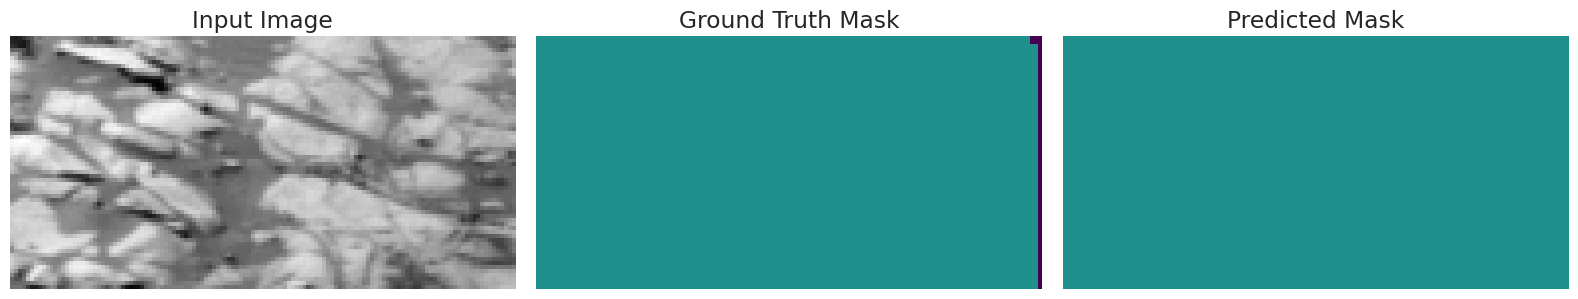

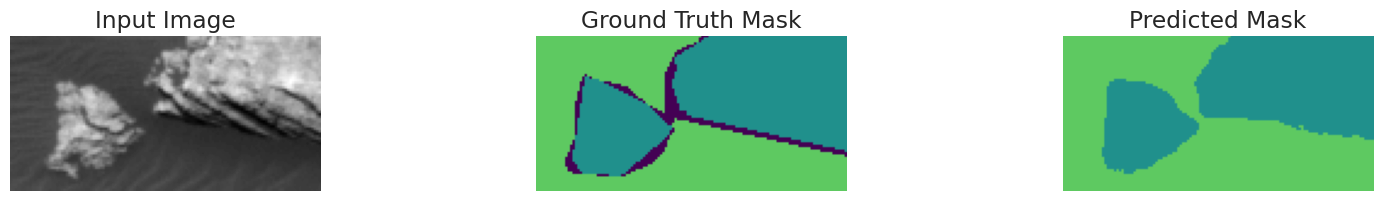

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6882 - loss: 0.2863 - mean_iou: 0.6535 - val_accuracy: 0.6778 - val_loss: 0.3203 - val_mean_iou: 0.6062 - learning_rate: 1.0000e-05
SCCE weight: 0.4577 - dice weight: 0.1694 - boundary weight: 0.3730
Epoch 82/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6925 - loss: 0.2852 - mean_iou: 0.6575 - val_accuracy: 0.6772 - val_loss: 0.3206 - val_mean_iou: 0.6053 - learning_rate: 1.0000e-05
SCCE weight: 0.4582 - dice weight: 0.1674 - boundary weight: 0.3745
Epoch 83/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6857 - loss: 0.2857 - mean_iou: 0.6489 - val_accuracy: 0.6766 - val_loss: 0.3209 - val_mean_iou: 0.6044 - learning_rate: 1.0000e-05
SCCE weight: 0.4587 - dice weight: 0.1654 - boundary weight: 0.3760
Epoch 84/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6910 - loss: 0.2823 - mean_iou: 0.6557 - val_accuracy: 0.6764 - val_loss: 0.3214 - val_mean_iou: 0.6043 - learning_rate: 1.0000e-05
SCCE weight: 0.45

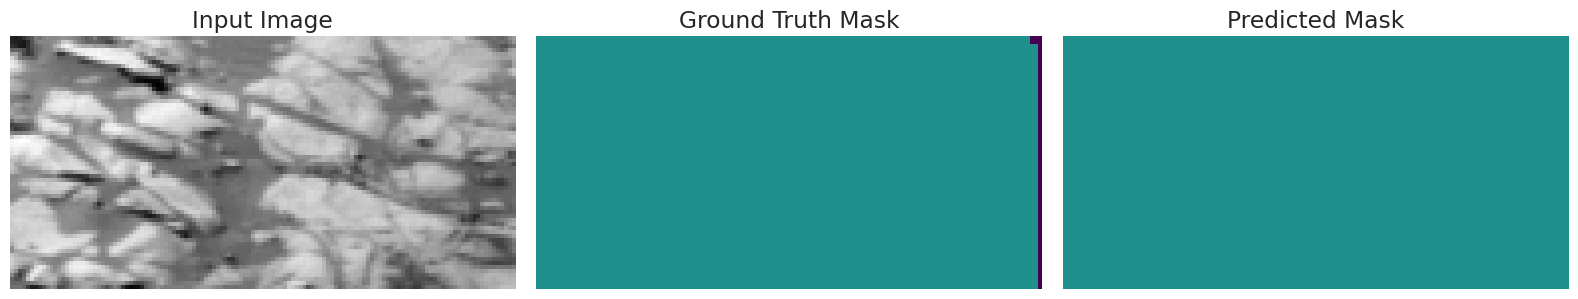

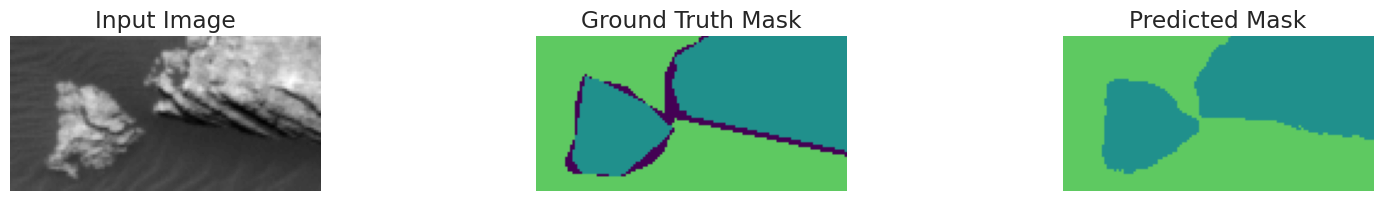

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6882 - loss: 0.2850 - mean_iou: 0.6524 - val_accuracy: 0.6754 - val_loss: 0.3217 - val_mean_iou: 0.6026 - learning_rate: 1.0000e-05
SCCE weight: 0.4601 - dice weight: 0.1594 - boundary weight: 0.3804
Epoch 87/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6877 - loss: 0.2874 - mean_iou: 0.6463 - val_accuracy: 0.6751 - val_loss: 0.3218 - val_mean_iou: 0.6021 - learning_rate: 1.0000e-05
SCCE weight: 0.4606 - dice weight: 0.1575 - boundary weight: 0.3819
Epoch 88/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6882 - loss: 0.2859 - mean_iou: 0.6523 - val_accuracy: 0.6750 - val_loss: 0.3219 - val_mean_iou: 0.6020 - learning_rate: 1.0000e-05
SCCE weight: 0.4611 - dice weight: 0.1556 - boundary weight: 0.3833
Epoch 89/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6878 - loss: 0.2856 - mean_iou: 0.6546 - val_accuracy: 0.6753 - val_loss: 0.3219 - val_mean_iou: 0.6024 - learning_rate: 1.0000e-05
SCCE weight: 0.46

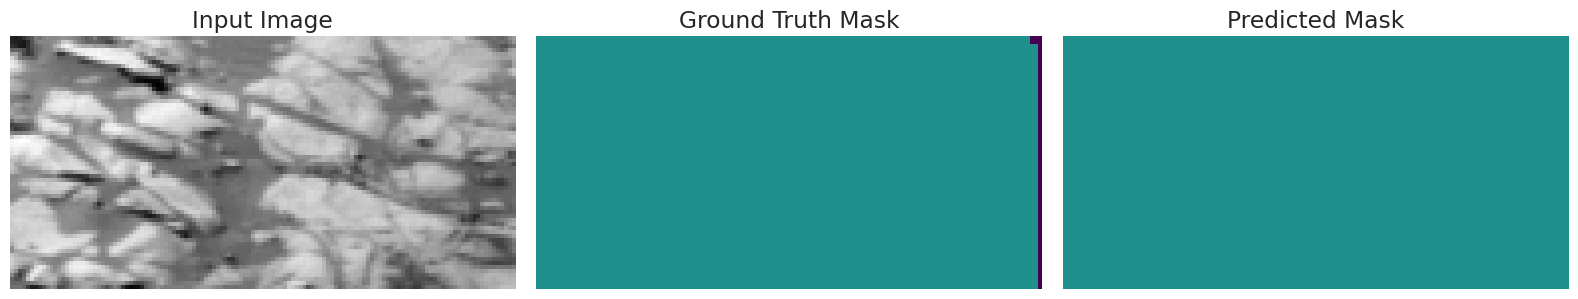

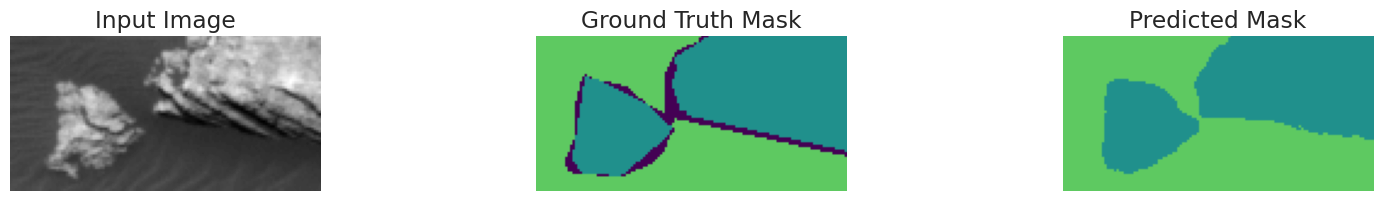

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6899 - loss: 0.2816 - mean_iou: 0.6546 - val_accuracy: 0.6753 - val_loss: 0.3218 - val_mean_iou: 0.6025 - learning_rate: 1.0000e-05
SCCE weight: 0.4625 - dice weight: 0.1498 - boundary weight: 0.3876
Epoch 92/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6887 - loss: 0.2869 - mean_iou: 0.6449 - val_accuracy: 0.6752 - val_loss: 0.3219 - val_mean_iou: 0.6022 - learning_rate: 1.0000e-06
SCCE weight: 0.4630 - dice weight: 0.1479 - boundary weight: 0.3890
Epoch 93/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6829 - loss: 0.2922 - mean_iou: 0.6408 - val_accuracy: 0.6751 - val_loss: 0.3219 - val_mean_iou: 0.6021 - learning_rate: 1.0000e-06
SCCE weight: 0.4635 - dice weight: 0.1461 - boundary weight: 0.3904
Epoch 94/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6899 - loss: 0.2856 - mean_iou: 0.6506 - val_accuracy: 0.6752 - val_loss: 0.3218 - val_mean_iou: 0.6022 - learning_rate: 1.0000e-06
SCCE weight: 0.46

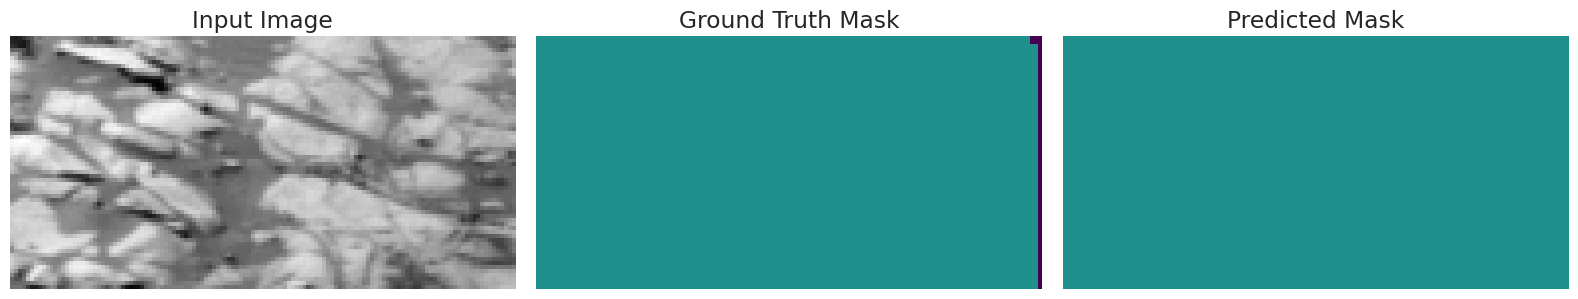

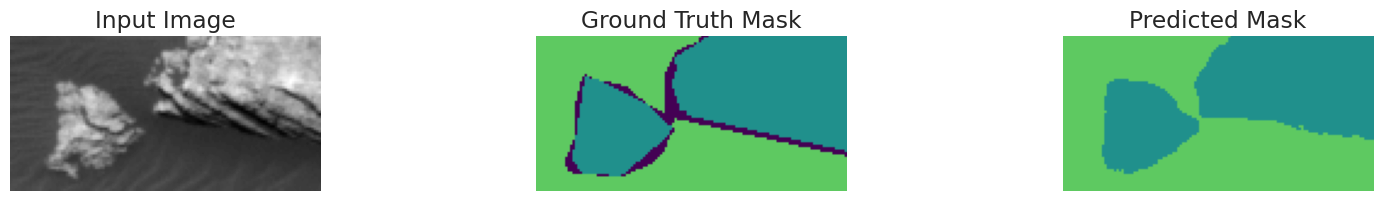

32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6909 - loss: 0.2817 - mean_iou: 0.6568 - val_accuracy: 0.6750 - val_loss: 0.3219 - val_mean_iou: 0.6019 - learning_rate: 1.0000e-06
SCCE weight: 0.4649 - dice weight: 0.1405 - boundary weight: 0.3946
Epoch 97/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6930 - loss: 0.2836 - mean_iou: 0.6650 - val_accuracy: 0.6750 - val_loss: 0.3219 - val_mean_iou: 0.6020 - learning_rate: 1.0000e-06
SCCE weight: 0.4653 - dice weight: 0.1387 - boundary weight: 0.3960
Epoch 98/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6919 - loss: 0.2862 - mean_iou: 0.6501 - val_accuracy: 0.6748 - val_loss: 0.3220 - val_mean_iou: 0.6016 - learning_rate: 1.0000e-06
SCCE weight: 0.4658 - dice weight: 0.1369 - boundary weight: 0.3973
Epoch 99/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6952 - loss: 0.2827 - mean_iou: 0.6606 - val_accuracy: 0.6747 - val_loss: 0.3220 - val_mean_iou: 0.6016 - learning_rate: 1.0000e-06
SCCE weight: 0.46

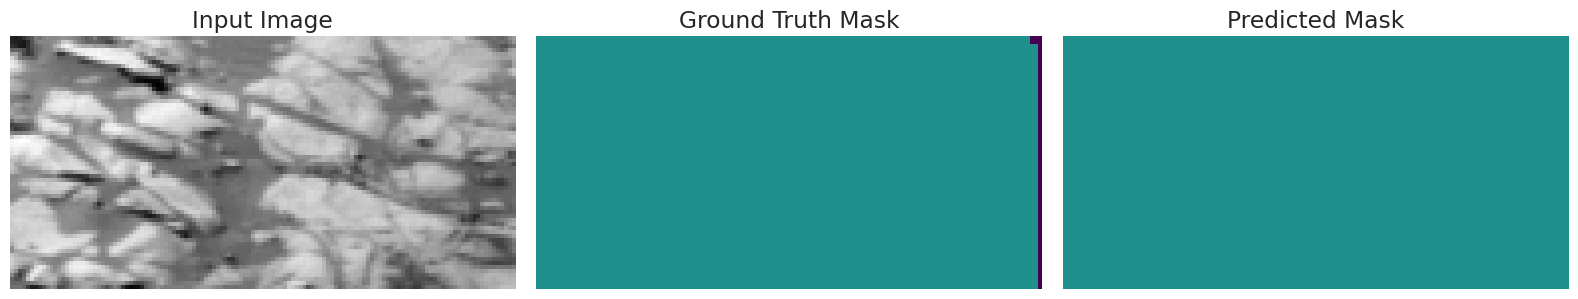

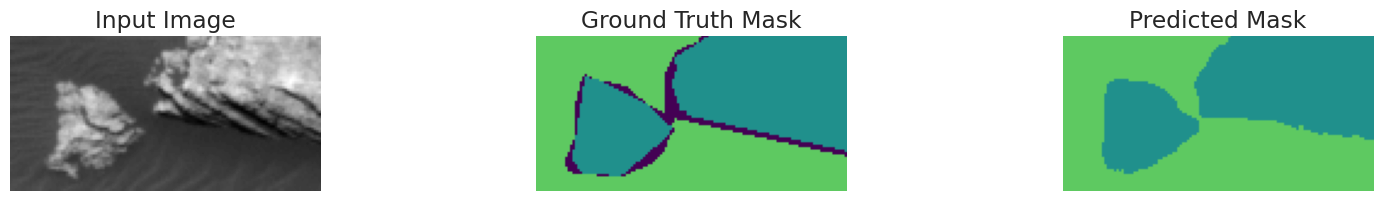

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6890 - loss: 0.2847 - mean_iou: 0.6425 - val_accuracy: 0.6747 - val_loss: 0.3221 - val_mean_iou: 0.6015 - learning_rate: 1.0000e-06
SCCE weight: 0.4671 - dice weight: 0.1316 - boundary weight: 0.4013
Epoch 102/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6801 - loss: 0.2965 - mean_iou: 0.6332 - val_accuracy: 0.6747 - val_loss: 0.3221 - val_mean_iou: 0.6014 - learning_rate: 1.0000e-07
SCCE weight: 0.4675 - dice weight: 0.1298 - boundary weight: 0.4026
Epoch 103/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6893 - loss: 0.2820 - mean_iou: 0.6568 - val_accuracy: 0.6747 - val_loss: 0.3221 - val_mean_iou: 0.6015 - learning_rate: 1.0000e-07
SCCE weight: 0.4680 - dice weight: 0.1281 - boundary weight: 0.4040
Epoch 104/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6927 - loss: 0.2843 - mean_iou: 0.6468 - val_accuracy: 0.6748 - val_loss: 0.3220 - val_mean_iou: 0.6016 - learning_rate: 1.0000e-07
SCCE weight: 0

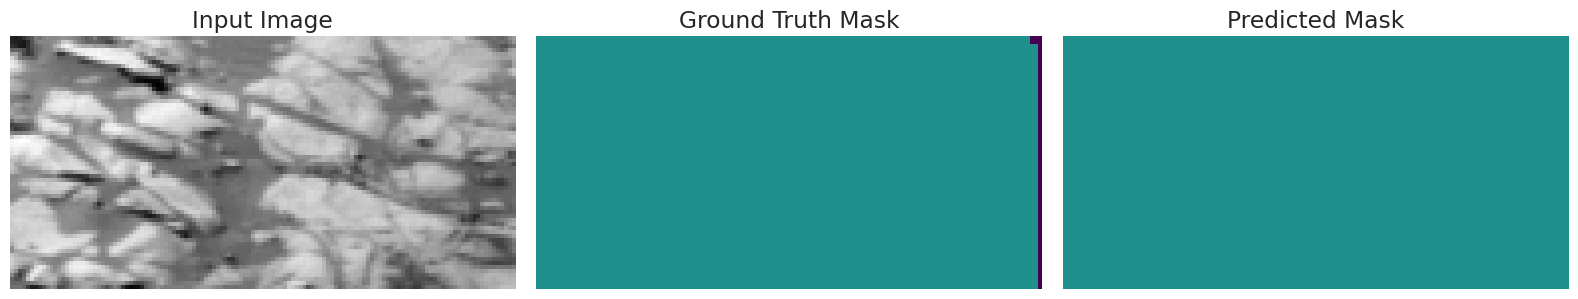

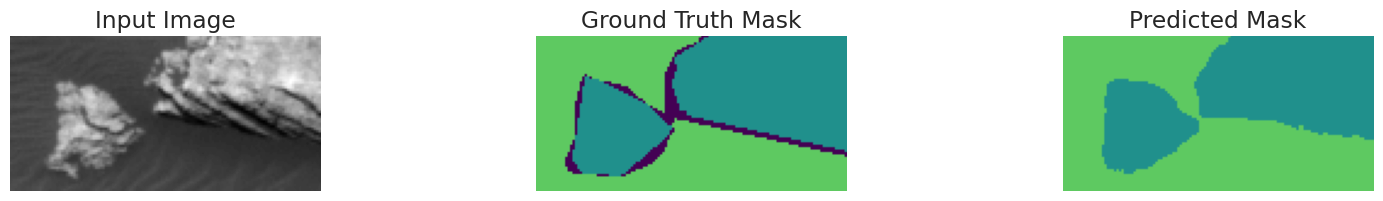

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6912 - loss: 0.2828 - mean_iou: 0.6562 - val_accuracy: 0.6747 - val_loss: 0.3221 - val_mean_iou: 0.6015 - learning_rate: 1.0000e-07
SCCE weight: 0.4693 - dice weight: 0.1229 - boundary weight: 0.4078
Epoch 107/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6907 - loss: 0.2844 - mean_iou: 0.6545 - val_accuracy: 0.6748 - val_loss: 0.3220 - val_mean_iou: 0.6016 - learning_rate: 1.0000e-07
SCCE weight: 0.4697 - dice weight: 0.1212 - boundary weight: 0.4091
Epoch 108/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6875 - loss: 0.2889 - mean_iou: 0.6490 - val_accuracy: 0.6747 - val_loss: 0.3221 - val_mean_iou: 0.6015 - learning_rate: 1.0000e-07
SCCE weight: 0.4701 - dice weight: 0.1195 - boundary weight: 0.4104
Epoch 109/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6843 - loss: 0.2879 - mean_iou: 0.6433 - val_accuracy: 0.6746 - val_loss: 0.3222 - val_mean_iou: 0.6013 - learning_rate: 1.0000e-07
SCCE weight: 0

In [34]:
# Train the model
history = model.fit( 
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, epoch_tracker, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

#del model

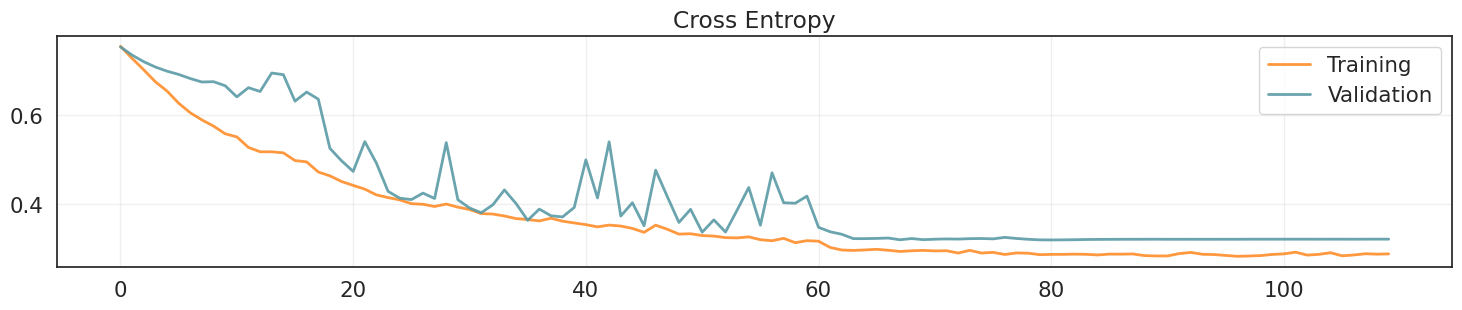

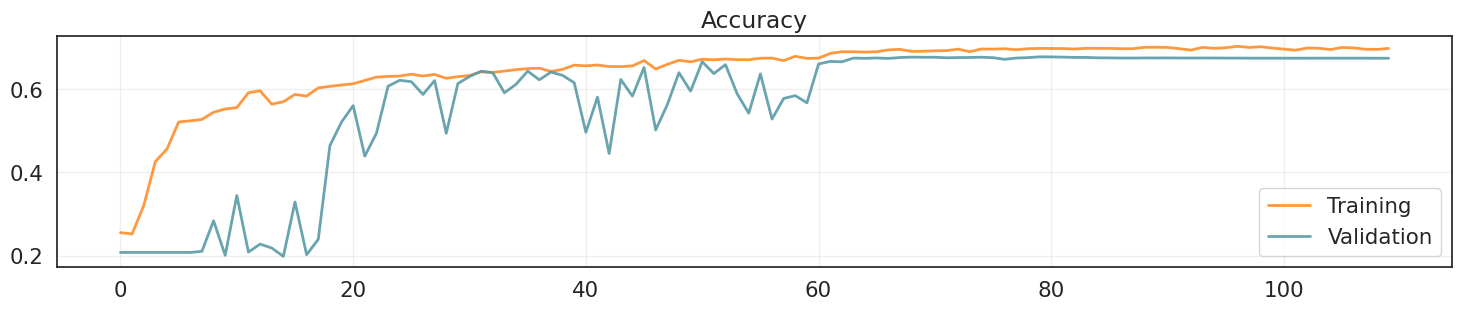

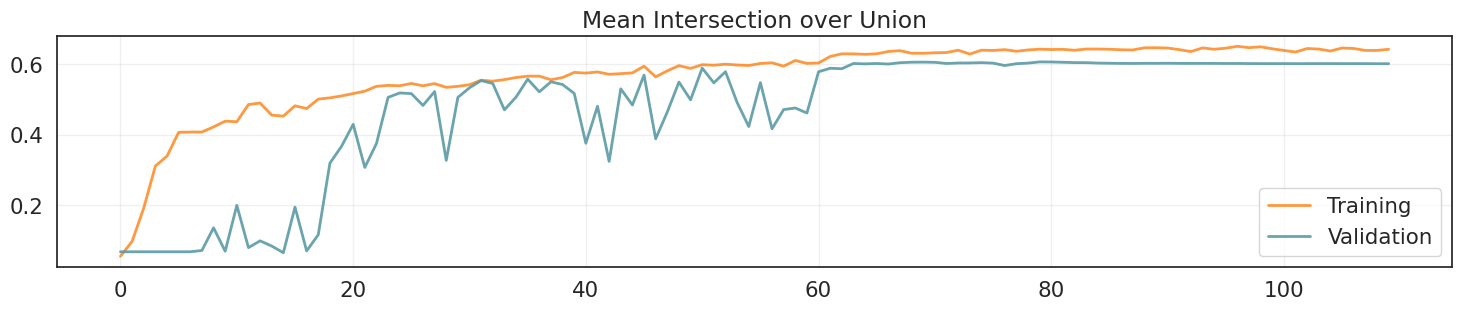

In [35]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [36]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [37]:
'''
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")
'''

'\nmodel = tfk.models.load_model(model_filename, compile=False)\nprint(f"Model loaded from {model_filename}")\n'

In [38]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 119s 254ms/step
Predictions shape: (10022, 64, 128)


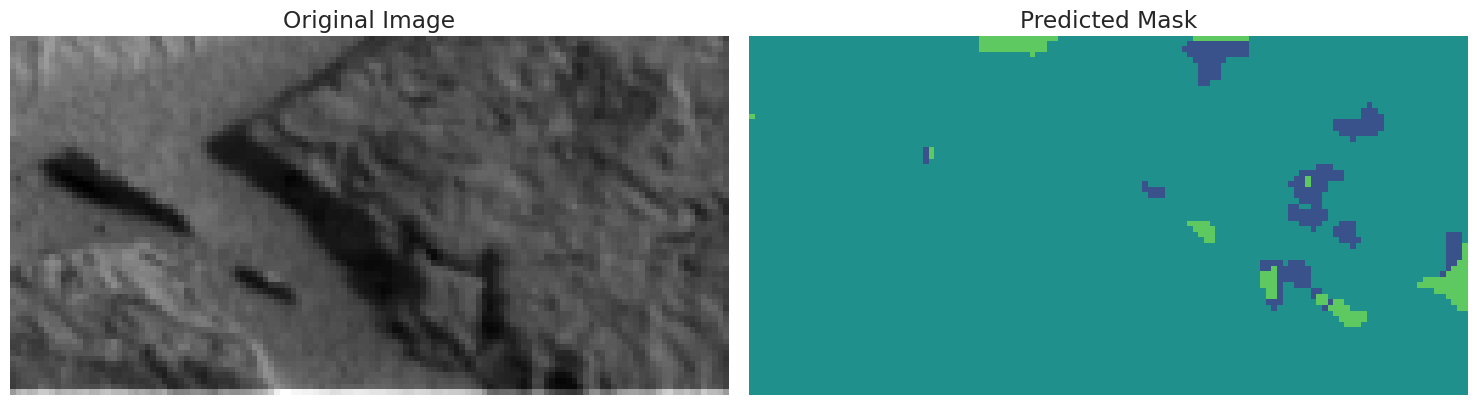

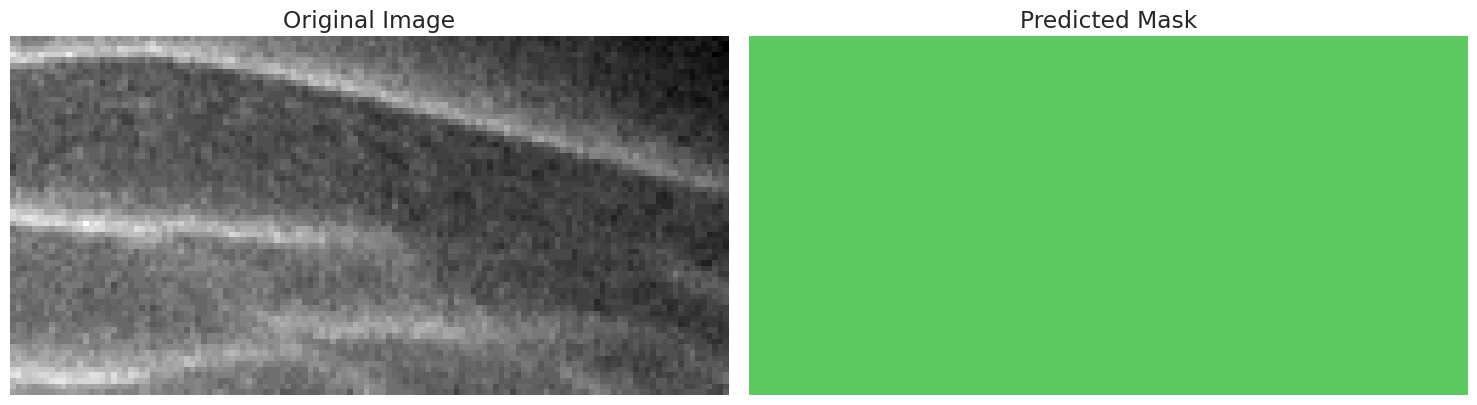

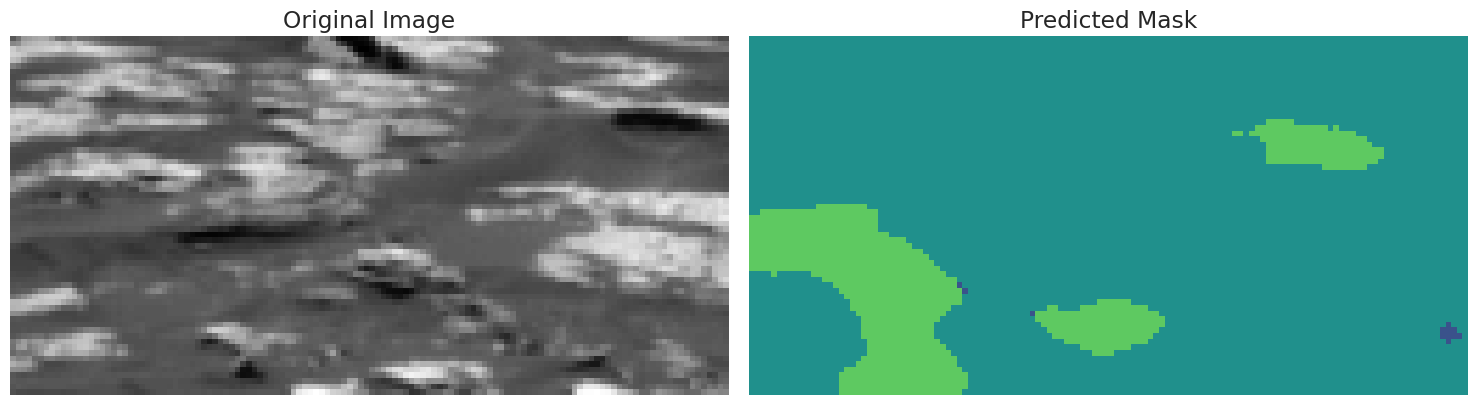

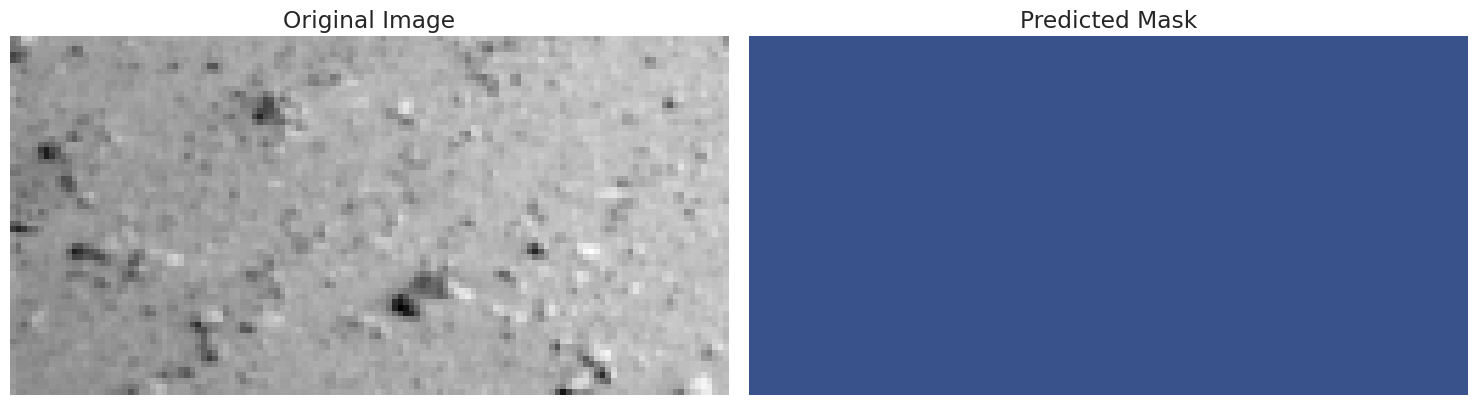

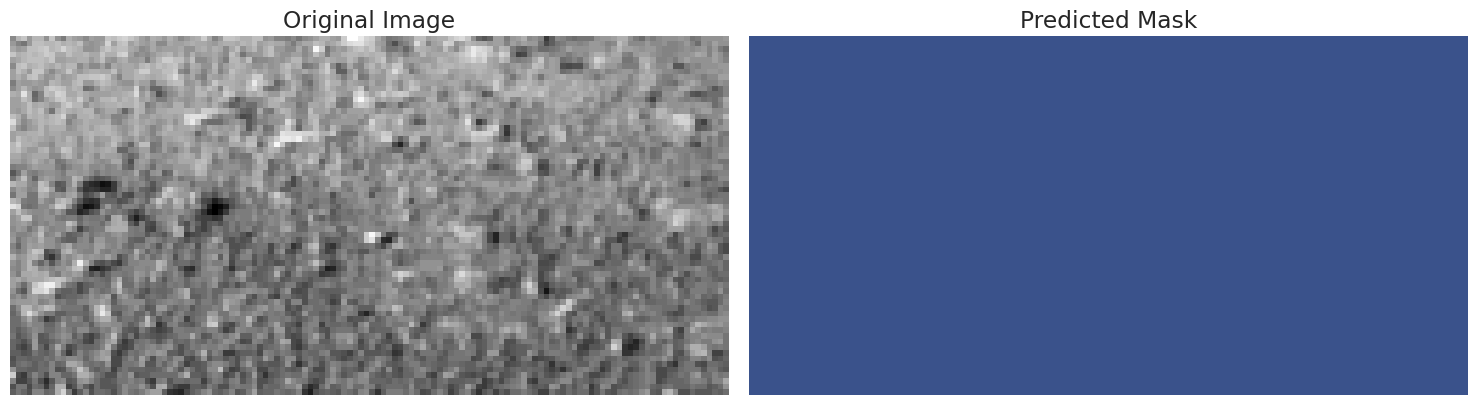

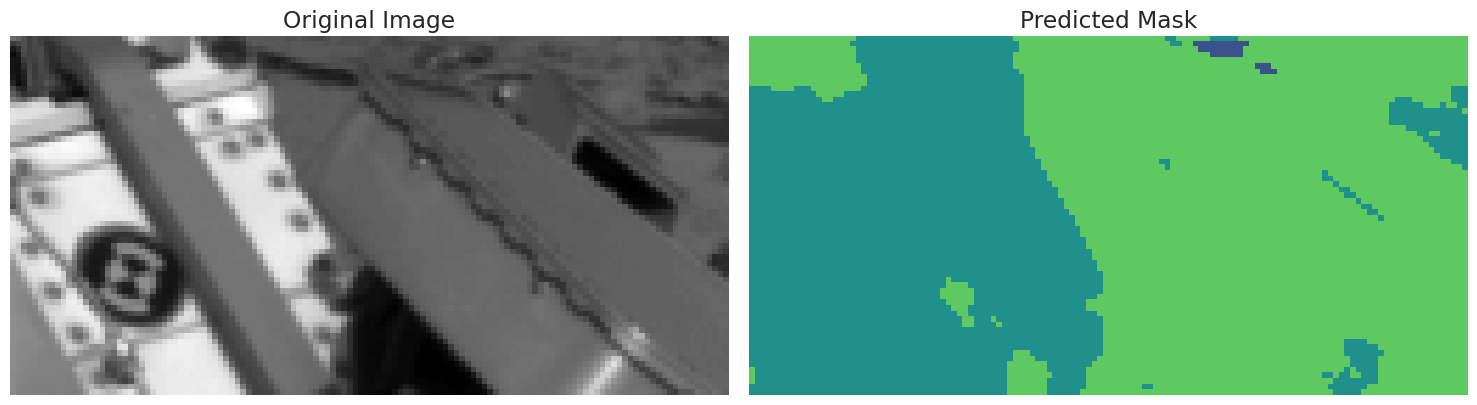

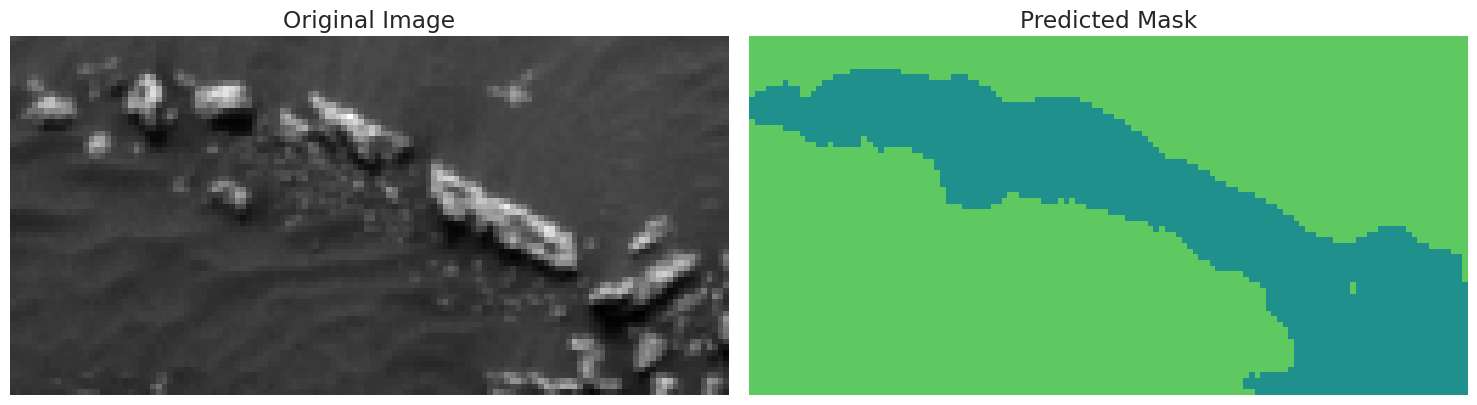

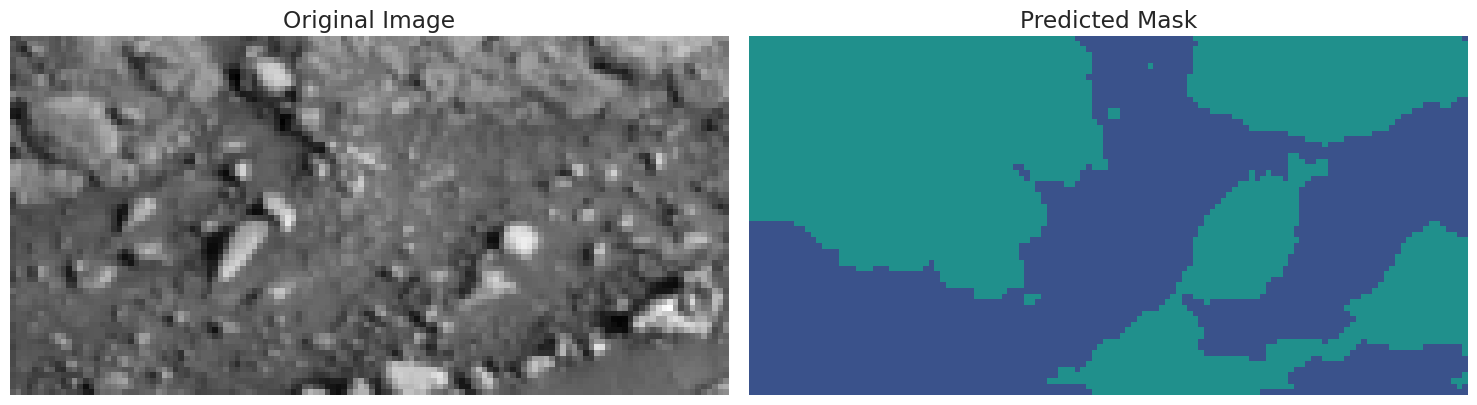

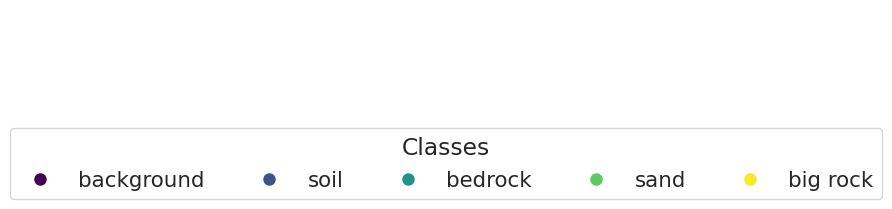

In [39]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [40]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [41]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [42]:
del model